Estudiante: Laura Melisa Gaviria Tapias

CC: 1035232148

El presente trabajo de monografía tiene como objetivo analizar la elasticidad precio de la demanda de productos de papel higiénico (Bathroom Tissue) utilizando el conjunto de datos Dominicks-Manual-and-Codebook_KiltsCenter. Este dataset, proporcionado por el Kilts Center for Marketing de la Universidad de Chicago, contiene información real detallada sobre precios, volúmenes de venta y características de productos comercializados en la cadena de supermercados Dominick's.

Este notebook documenta el proceso completo del análisis, incluyendo la preparación y limpieza de los datos, la exploración inicial, 4 modelos de machine learning(Arboles de decisión, Random Forest, Moment T5,  feed-forward neural network) para predecir y analizar la elasticidad del precio basado en las promociones aplicadas, resultados y conclusiones. El objetivo es contribuir al entendimiento de las dinámicas de mercado de bienes de consumo masivo, para luego proponer su implementación en empresas del mercado Colombiano.

El dataset cuenta con 2 conjuntos de datos:
1. UPC (Universal product code) corresponde datos de información de los productos, códigos, descripción, tamaño.
2. Archivo de movimientos, contiene data de ventas semanales por UPC, de 5 años, precios, promociones, margen de ganancia, tienda, otros.

**Variable Description Type Length**

**upc**: universal Product code numérico 8

**store**: número de tienda numérico  3

**week**: número de semana numérico  3

**move**: Cantidad vendida numérico  8

**price**: Precio retail numérico  8

**qty**: Número de articulos juntos numérico  3

**profit**: Margen de ganancia numérico  8

**sale**: código de promoción (B(Bono),C(Cupón),S(reducción simple de precio)) Character 8

**ok**: 1 para datos validos, 0 datos sospechosos numérico  

# **Librerias**

In [124]:
#Librerias a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Esto es para que en el archivo de requirements(donde se guardan las librerias a usar) se la exactamente las versiones que se tienen de las librerias
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {plt.matplotlib.__version__}") # Matplotlib tiene su versión en el submódulo
print(f"seaborn version: {sns.__version__}")
print(f"scikit-learn version: {sns.__version__}")

pandas version: 2.2.3
numpy version: 2.2.6
matplotlib version: 3.10.3
seaborn version: 0.13.2
scikit-learn version: 0.13.2


# **Lectura de datos**

In [2]:
#Esto se hace si se fuera a ejecutar en un notebook de Colab
#Acá montamos el Drive para poder leer los datasets desde la carpeta de drive 
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Para leer upcti.csv desde la carpeta 'data'
ruta_upcti = 'data/upctti.csv'
df_master = pd.read_csv(ruta_upcti) #Llamamos dataframe master ya que contiene datos maestros de las referencias
print(df_master.head())

# Para leer wtii.csv desde la carpeta 'data'
ruta_wtii = 'data/wtti.csv'
df_move = pd.read_csv(ruta_wtii)#Llamamos dataframe move ya que contiene datos de movimientos de las referencias
print(df_move.head())

   COM_CODE         UPC               DESCRIP   SIZE  CASE    NITEM
0       552  1122542346  VT BATH TISSUE 2 PLY   8 CT    12  1103571
1       552  3040000048  ANGEL SFT BTH TISSUE   4 CT    24  1103311
2       552  3040000069     ANGEL SOFT PASTEL   6 CT    16  1103331
3       552  3040000087  ANGEL SOFT WHITE BAT  12 CT     8  1103301
4       552  3040000104  ANGEL SOFT KIDS PRIN   4 CT    24  1103321
   STORE         UPC  WEEK  MOVE  PRICE  QTY SALE  PROFIT  OK  \
0      2  1122542346   336     0   0.00    1  NaN     0.0   1   
1      2  1122542346   337     0   0.00    1  NaN     0.0   1   
2      2  1122542346   338     1   2.09    1  NaN    13.3   1   
3      2  1122542346   339     4   2.09    1  NaN    13.3   1   
4      2  1122542346   340     7   2.09    1  NaN    13.3   1   

          PRICE_HEX        PROFIT_HEX  
0  0000000000000000  0000000000000000  
1  0000000000000000  0000000000000000  
2  4000B851EB851EB8  402A99999999999A  
3  4000B851EB851EB8  402A99999999999A  
4

In [4]:
#Leemos las rutas de los 2 datasets que están en formato CSV a utilizar y creamos los dataframes
#Llamamos df_master al dataframe que contiene los datos maestros: código de referencia, descripción de referencia
#ruta_master = "/content/drive/MyDrive/Universidad/Especialización Analítica/Monografia/Proyecto_dominicks/upctti.csv"
#ruta_move = "/content/drive/MyDrive/Universidad/Especialización Analítica/Monografia/Proyecto_dominicks/wtti.csv"
#df_master = pd.read_csv(ruta_master)
#df_move = pd.read_csv(ruta_move)

# **Exploración de los dataset**

In [20]:
#Miramos las dimensiones de los dataset que tenemos
sf_master = df_master.shape
sf_move = df_move.shape

print(sf_master)
print(sf_move)

(128, 6)
(1159016, 11)


El dataset de master tiene 128 filas, lo que quiere decir que se cuenta con 128 referencias y 6 columnas que describen las referencias.
El dataset de movimientos, donde están registradas las ventas, precios, descuentos y demás datos de interés para los modelos tiene 11 columnas y 1'627.284 filas.

## **Exploración dataset master**

In [21]:
#Exploración de los datos del archivo master
print("Primeras filas de df_master:")
print(df_master.head())

Primeras filas de df_master:
   com_code         upc               descrip   size  case    nitem
0       552  1122542346  VT BATH TISSUE 2 PLY   8 CT    12  1103571
1       552  3040000048  ANGEL SFT BTH TISSUE   4 CT    24  1103311
2       552  3040000069     ANGEL SOFT PASTEL   6 CT    16  1103331
3       552  3040000087  ANGEL SOFT WHITE BAT  12 CT     8  1103301
4       552  3040000104  ANGEL SOFT KIDS PRIN   4 CT    24  1103321


Convertimos todas los textos de ambos dataset que contengan mayúsculas a minúsculas para evitar problemas en el código y facilitar la exploración.

In [22]:
df_master.columns = df_master.columns.str.lower()
print("Nombres de las columnas de df_master en minúsculas:")
print(df_master.columns)
df_move.columns = df_move.columns.str.lower()
print("\nNombres de las columnas de df_move en minúsculas:")
print(df_move.columns)

Nombres de las columnas de df_master en minúsculas:
Index(['com_code', 'upc', 'descrip', 'size', 'case', 'nitem'], dtype='object')

Nombres de las columnas de df_move en minúsculas:
Index(['store', 'upc', 'week', 'move', 'price', 'qty', 'sale', 'profit', 'ok',
       'price_hex', 'profit_hex'],
      dtype='object')


In [23]:
print("\nInformación de df_master:")
df_master.info()


Información de df_master:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   com_code  128 non-null    int64 
 1   upc       128 non-null    int64 
 2   descrip   128 non-null    object
 3   size      128 non-null    object
 4   case      128 non-null    int64 
 5   nitem     128 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 6.1+ KB


In [24]:
print("\nAlgunos valores únicos en la columna 'descrip' de df_master:")
print(df_master['descrip'].unique()[:20]) # Muestra los primeros 20 valores únicos
print(f"\nNúmero total de descripciones únicas: {df_master['descrip'].nunique()}")


Algunos valores únicos en la columna 'descrip' de df_master:
['VT BATH TISSUE 2 PLY' 'ANGEL SFT BTH TISSUE' 'ANGEL SOFT PASTEL'
 'ANGEL SOFT WHITE BAT' 'ANGEL SOFT KIDS PRIN' 'ANGEL SOFT BUNDLE PA'
 '~CORONET KING' 'CORONET BATH TISSUE' 'CORONET BATH TISSUES'
 'KLEENEX PP1.09' 'DELSEY ASSORT TOILET' 'KLEENEX COTTONELLE U'
 'KLEENEX ULTRA DBL 12' 'KLEENEX BATH WHITE' 'KLNX TRL SHPR DBL RO'
 'KLEENEX/CNTL 4DBL RL' 'KLEENEX BATH PRINTS' '~KLEENEX DBL ROLL AS'
 'KLEENEX DBL 4-ROLL P' 'KLEENEX DBL ROLL FRE']

Número total de descripciones únicas: 110


## **Exploración dataset de movimientos**

Exploramos las variables que se tienen en el dataset de movimientos, ya que el master, como corresponde a información de identificación no se realiza estadísticas descriptivas.

In [25]:
print("\nColumnas de df_move:")
print(df_move.columns)


Columnas de df_move:
Index(['store', 'upc', 'week', 'move', 'price', 'qty', 'sale', 'profit', 'ok',
       'price_hex', 'profit_hex'],
      dtype='object')


In [26]:
print("\nInformación de df_move:")
df_move.info()


Información de df_move:
<class 'pandas.core.frame.DataFrame'>
Index: 1159016 entries, 2 to 1627225
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   store       1159016 non-null  int64  
 1   upc         1159016 non-null  int64  
 2   week        1159016 non-null  int64  
 3   move        1159016 non-null  int64  
 4   price       1159016 non-null  float64
 5   qty         1159016 non-null  int64  
 6   sale        230779 non-null   object 
 7   profit      1159016 non-null  float64
 8   ok          1159016 non-null  int64  
 9   price_hex   1159016 non-null  object 
 10  profit_hex  1159016 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 106.1+ MB


In [27]:
descripcion = df_move.describe()
descripcion_formateada = descripcion.applymap('{:.2f}'.format)

print("\nEstadísticas descriptivas de df_move (con 2 decimales):")
print(descripcion_formateada)


Estadísticas descriptivas de df_move (con 2 decimales):
            store            upc        week        move       price  \
count  1159016.00     1159016.00  1159016.00  1159016.00  1159016.00   
mean        83.43  4482190242.96      211.58       75.57        2.10   
std         36.63  1044151065.14      112.79      294.02        1.84   
min          2.00  1122542346.00        1.00        1.00        0.19   
25%         56.00  3700060511.00      118.00       12.00        0.99   
50%         89.00  4200013000.00      213.00       28.00        1.48   
75%        113.00  5400046530.00      308.00       63.00        2.59   
max        146.00  7572536485.00      399.00    69394.00      838.16   

              qty      profit          ok  
count  1159016.00  1159016.00  1159016.00  
mean         1.03       16.64        0.99  
std          0.30       11.15        0.09  
min          1.00      -99.88        0.00  
25%          1.00        9.77        1.00  
50%          1.00       16.86 

C:\Users\cohlagv\AppData\Local\Temp\ipykernel_18460\1243890937.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  descripcion_formateada = descripcion.applymap('{:.2f}'.format)


Aunque algunas variables figuran como enteros, se refieren a variables de texto, como la upc, store, week. Por lo que estas variables se deben convertir a tipo string.

In [28]:
print(f"\nNúmero total de tiendas: {df_move['store'].nunique()}")


Número total de tiendas: 93


In [29]:
print("\nDistribución de las primeras semanas en df_move:")
print(df_move['week'].value_counts().head())
print(f"\nNúmero total de semanas: {df_move['week'].nunique()}")


Distribución de las primeras semanas en df_move:
week
348    3715
350    3712
349    3707
344    3667
356    3665
Name: count, dtype: int64

Número total de semanas: 384


### **Creación de datos sintéticos**

Debido a que contamos con datos solo desde 1989 a 1994 se propone crear datos sintéticos para tener más data. 
Para la creación de los datos sintéticos primero se realiza un análisis descriptivo de la siguiente forma:

1. Estadísticas de resumen
2. Distribuciones de las variables numéricas
3. Análisis de frecuencias de las variables categóricas
4. Relaciones entre las variables (Correlaciones y relaciones entre las variables categóricas y númericas)
5. Análisis de tendencia y de estacionalidad

#### **Estadísticas de resumen**

In [57]:
# Convertir la variable 'week' a numérico y eliminar errores
df_move['week'] = pd.to_numeric(df_move['week'], errors='coerce').dropna().astype(int)

In [58]:
# Análisis Descriptivo Básico
print("Estadísticas Resumen:")
print(df_move[['move', 'price', 'qty', 'profit']].describe().round(2))


Estadísticas Resumen:
             move       price         qty      profit
count  1159016.00  1159016.00  1159016.00  1159016.00
mean        75.57        2.10        1.03       16.64
std        294.02        1.84        0.30       11.15
min          1.00        0.19        1.00      -99.88
25%         12.00        0.99        1.00        9.77
50%         28.00        1.48        1.00       16.86
75%         63.00        2.59        1.00       22.49
max      69394.00      838.16        7.00       99.94


Como tenemos 0 en precio y ventas(move), se deben eliminar estos ya que son variables esenciales para el análisis.

In [59]:
df_move_cleaned = df_move[~((df_move['move'] == 0) | (df_move['price'] == 0))].copy()
df_move = df_move_cleaned

In [60]:
print("Estadísticas Resumen:")
print(df_move[['move', 'price', 'qty', 'profit']].describe().round(2))

Estadísticas Resumen:
             move       price         qty      profit
count  1159016.00  1159016.00  1159016.00  1159016.00
mean        75.57        2.10        1.03       16.64
std        294.02        1.84        0.30       11.15
min          1.00        0.19        1.00      -99.88
25%         12.00        0.99        1.00        9.77
50%         28.00        1.48        1.00       16.86
75%         63.00        2.59        1.00       22.49
max      69394.00      838.16        7.00       99.94


(0.0, 1000.0)

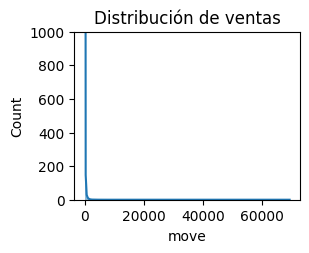

In [61]:
#Gráfico para las ventas
plt.subplot(2, 2, 2)
sns.histplot(df_move['move'], kde=True)
plt.title('Distribución de ventas')
plt.ylim(0, 1000)

(0.0, 1000.0)

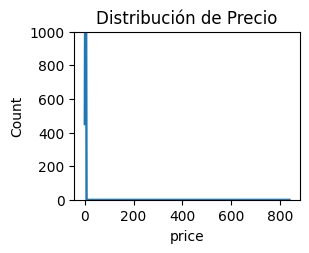

In [62]:
#Gráfico para el precio
plt.subplot(2, 2, 2)
sns.histplot(df_move['price'], kde=True)
plt.title('Distribución de Precio')
plt.ylim(0, 1000)

Con los graficos para identificar la distribucción, vemos que cuenta con valores atípicos que distorcionan un poco los gráficos, por lo que se hace necesario revisar estos valores y tratarlos para poder hacer un mejor análisis de las distribuciones:
1. Se hace un análsis de los valores atípicos revisando si hay valores que estén relacionados con promociones(variable sale)
2. Si hay valores atípicos que no están relacionados con promociones entonces se decide tratarlos

In [63]:
# Calcular los cuartiles y el IQR para 'move' 
Q1_move = df_move['move'].quantile(0.25)
Q3_move = df_move['move'].quantile(0.75)
IQR_move = Q3_move - Q1_move

# Definir los límites para identificar valores atípicos superiores en 'move'
upper_bound_move = Q3_move + 1.5 * IQR_move

# Filtrar el DataFrame para obtener solo los valores atípicos superiores de 'move'
outliers_move = df_move[df_move['move'] > upper_bound_move]

# Mostrar la frecuencia de los tipos de promoción ('sale') para estos valores atípicos
print("\nFrecuencia de promociones ('sale') para valores atípicos superiores en 'move':")
print(outliers_move['sale'].value_counts(dropna=False))

# Repetir el proceso para 'price' (opcional, si también te interesan sus atípicos)
Q1_price = df_move['price'].quantile(0.25)
Q3_price = df_move['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
upper_bound_price = Q3_price + 1.5 * IQR_price
outliers_price = df_move[df_move['price'] > upper_bound_price]
print("\nFrecuencia de promociones ('sale') para valores atípicos superiores en 'price':")
print(outliers_price['sale'].value_counts(dropna=False))


Frecuencia de promociones ('sale') para valores atípicos superiores en 'move':
sale
NaN    62965
B      32858
S      24337
G        149
C         71
Name: count, dtype: int64

Frecuencia de promociones ('sale') para valores atípicos superiores en 'price':
sale
NaN    60029
B       3777
S       1977
Name: count, dtype: int64


Ya que tenemos varios NaN, se analiza si estos valores Nan se pueden asociar a algún tipo de promoción, dado que en la documentación de dataset se menciona que hay valores que pueden ser promociones pero no estar catalogados como tal.
Entonces hacemos un análisis descriptivo, agrupado por tipo de promocióon y luego revisamos si podemos clasificar algunos datos dentro de alguna de estas categorias S, B, C, G

In [64]:
# --- Calcular estadísticas descriptivas de 'move' agrupadas por 'sale' ---
print("\nEstadísticas descriptivas de 'move' agrupadas por 'sale':")
print(df_move_cleaned.groupby('sale',dropna=False)['move'].describe())

# --- Calcular estadísticas descriptivas de 'price' agrupadas por 'sale' ---
print("\nEstadísticas descriptivas de 'price' agrupadas por 'sale':")
print(df_move_cleaned.groupby('sale', dropna=False)['price'].describe())


Estadísticas descriptivas de 'move' agrupadas por 'sale':
         count        mean         std   min    25%    50%     75%      max
sale                                                                       
B     173147.0  124.757414  506.283181   1.0   21.0   48.0   108.0  69394.0
C        243.0  150.843621  218.856439   1.0   15.0   42.0   230.5   1291.0
G        170.0  841.535294  539.276978  31.0  441.5  797.0  1164.0   2455.0
S      57219.0  287.672818  693.586578   1.0   36.0  104.0   297.0  26343.0
NaN   928237.0   53.161408  163.022735   1.0   11.0   25.0    52.0  17920.0

Estadísticas descriptivas de 'price' agrupadas por 'sale':
         count      mean       std   min   25%   50%   75%     max
sale                                                              
B     173147.0  1.631080  2.332734  0.24  0.95  1.15  1.99  838.16
C        243.0  1.410741  0.662723  0.69  0.69  1.82  1.98    2.16
G        170.0  1.076353  0.589000  0.47  0.65  0.75  1.90    1.97
S      57219.0

In [65]:
# Filtrar el DataFrame para obtener los valores atípicos superiores de 'move' donde 'sale' es NaN
outliers_move_nan_sale = df_move_cleaned[(df_move_cleaned['move'] > upper_bound_move) & (df_move_cleaned['sale'].isna())]

# Mostrar las estadísticas descriptivas de 'move' para estos atípicos
print("\nEstadísticas descriptivas de 'move' para atípicos superiores con sale NaN:")
print(outliers_move_nan_sale['move'].describe())

#Filtrar el DataFrame para obtener los valores atípicos superiores de 'price' donde 'sale' es NaN
outliers_price_nan_sale = df_move_cleaned[(df_move_cleaned['price'] > upper_bound_price) & (df_move_cleaned['sale'].isna())]

# Mostrar las estadísticas descriptivas de 'price' para estos atípicos
print("\nEstadísticas descriptivas de 'price' para atípicos superiores con sale NaN:")
print(outliers_price_nan_sale['price'].describe())


Estadísticas descriptivas de 'move' para atípicos superiores con sale NaN:
count    62965.000000
mean       347.685238
std        535.780147
min        140.000000
25%        169.000000
50%        222.000000
75%        341.000000
max      17920.000000
Name: move, dtype: float64

Estadísticas descriptivas de 'price' para atípicos superiores con sale NaN:
count    60029.000000
mean         6.996796
std          1.217071
min          5.000000
25%          6.390000
50%          6.990000
75%          7.390000
max         11.990000
Name: price, dtype: float64


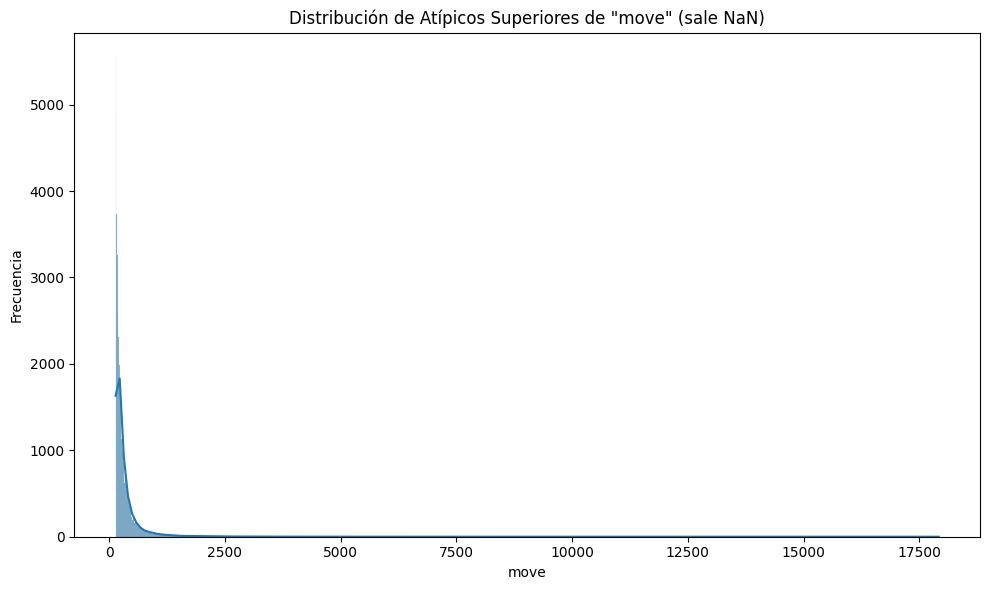

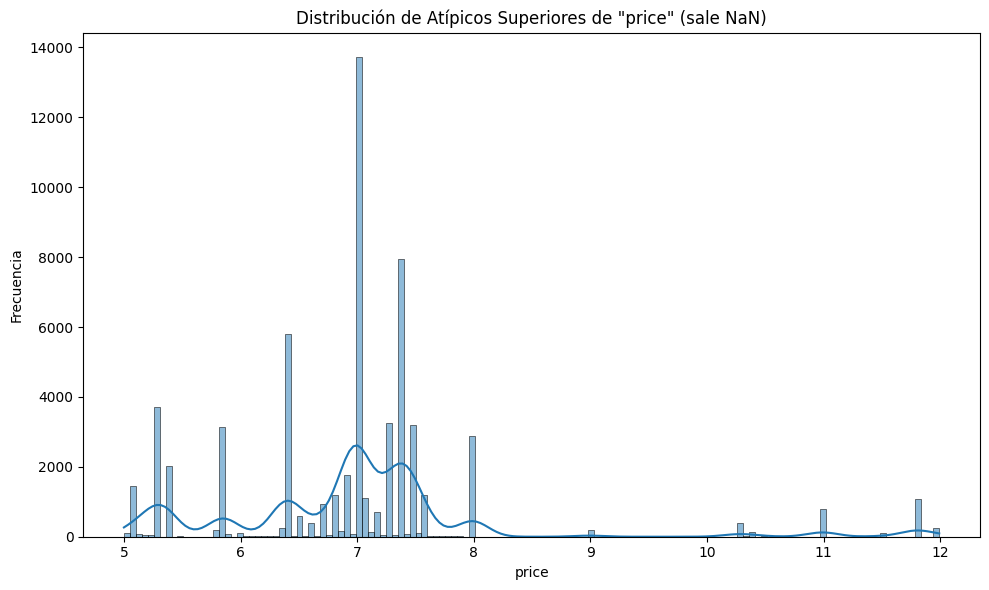

In [66]:
# --- Graficar la distribución de los atípicos de 'move' ---
plt.figure(figsize=(10, 6))
sns.histplot(outliers_move_nan_sale['move'], kde=True)
plt.title('Distribución de Atípicos Superiores de "move" (sale NaN)')
plt.xlabel('move')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# --- Graficar la distribución de los atípicos de 'price' ---
plt.figure(figsize=(10, 6))
sns.histplot(outliers_price_nan_sale['price'], kde=True)
plt.title('Distribución de Atípicos Superiores de "price" (sale NaN)')
plt.xlabel('price')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

Vemos que los estadisticos no son similares a los de ninguna categoría de sale, por lo que podría inferirse que pueden ser errores o algun tipo de promoción que no fue documentada.
Antes de tomar la decisión si se eliminan o no, se propone revisar a cuantas referencias corresponden estos datos atipicos, porque puede ser que si son pocas referencias, corresponda a algun tipo de liquidación.

In [67]:
# Obtener el número de UPCs únicos en este subconjunto
num_unique_upcs_outliers_price_nan_sale = outliers_price_nan_sale['upc'].nunique()
print(f"\nNúmero de UPCs únicos en atípicos superiores de 'price' con sale NaN: {num_unique_upcs_outliers_price_nan_sale}")

# Si el número de UPCs únicos es pequeño (por ejemplo, menos de 20), mostrar cuáles son
if num_unique_upcs_outliers_price_nan_sale < 20:
    unique_upcs_outliers_price_nan_sale = outliers_price_nan_sale['upc'].unique()
    print("\nUPCs de los atípicos superiores de 'price' con sale NaN:")
    print(unique_upcs_outliers_price_nan_sale)


Número de UPCs únicos en atípicos superiores de 'price' con sale NaN: 20


In [68]:
# Obtener las 20 UPCs únicas de este subconjunto
unique_upcs_outliers_price_nan_sale = outliers_price_nan_sale['upc'].unique()

# Filtrar el DataFrame original para incluir solo las filas correspondientes a estas 20 UPCs
#que también son atípicos superiores en 'price' y tienen 'sale' como NaN
specific_upc_outliers = df_move_cleaned[
    df_move_cleaned['upc'].isin(unique_upcs_outliers_price_nan_sale) &
    (df_move_cleaned['price'] > upper_bound_price) &
    (df_move_cleaned['sale'].isna())
]

#Calcular estadísticas descriptivas de 'move' por UPC
print("\nEstadísticas descriptivas de 'move' para atípicos superiores de 'price' (sale NaN) por UPC:")
print(specific_upc_outliers.groupby('upc')['move'].describe())

#Calcular estadísticas descriptivas de 'price' por UPC
print("\nEstadísticas descriptivas de 'price' para atípicos superiores de 'price' (sale NaN) por UPC:")
print(specific_upc_outliers.groupby('upc')['price'].describe())


Estadísticas descriptivas de 'move' para atípicos superiores de 'price' (sale NaN) por UPC:
             count       mean        std  min   25%   50%    75%    max
upc                                                                    
3040000107  1122.0   6.398396   4.996066  1.0   2.0   5.0   9.00   35.0
3600060630  3555.0   5.638256   4.187663  1.0   3.0   5.0   7.00   38.0
3600061520  3189.0   3.647852   2.857859  1.0   2.0   3.0   5.00   29.0
3600061800  6159.0   8.577854   6.859685  1.0   4.0   7.0  11.00   92.0
3600061900    63.0   4.269841   3.418198  1.0   1.5   3.0   6.00   15.0
3700006736   306.0   6.052288   4.738113  1.0   3.0   5.0   7.75   28.0
3700060303  2000.0  16.590500  10.550377  1.0   9.0  14.0  22.00   70.0
3700060311  4618.0  26.763751  20.493454  1.0  14.0  21.0  34.00  418.0
3700060949  1078.0   6.966605   4.692870  1.0   3.0   6.0  10.00   29.0
3700060954  4071.0   6.695407   5.367531  1.0   3.0   6.0   9.00  110.0
3700061301   830.0  12.868675  10.151606  1

In [69]:
# --- Filtrar el DataFrame para incluir solo las filas de estas 20 UPCs que NO son atípicos superiores en 'price' con sale NaN ---
normal_behavior_specific_upcs = df_move_cleaned[
    df_move_cleaned['upc'].isin(unique_upcs_outliers_price_nan_sale) &
    ~((df_move_cleaned['price'] > upper_bound_price) & (df_move_cleaned['sale'].isna()))
]

# --- Calcular estadísticas descriptivas de 'move' para estas UPCs en su comportamiento normal ---
print("\nEstadísticas descriptivas de 'move' para las 20 UPCs en su comportamiento normal:")
print(normal_behavior_specific_upcs.groupby('upc')['move'].describe())

# --- Calcular estadísticas descriptivas de 'price' para estas UPCs en su comportamiento normal ---
print("\nEstadísticas descriptivas de 'price' para las 20 UPCs en su comportamiento normal:")
print(normal_behavior_specific_upcs.groupby('upc')['price'].describe())


Estadísticas descriptivas de 'move' para las 20 UPCs en su comportamiento normal:
              count       mean        std  min    25%   50%     75%      max
upc                                                                         
3600060630    411.0  32.401460  27.411532  1.0  15.00  23.0   42.00    185.0
3600061520    287.0  15.449477  15.164715  1.0   6.00  11.0   19.00    119.0
3600061800    745.0  37.697987  41.120905  1.0  11.00  22.0   48.00    282.0
3600061900  11452.0   5.997992   4.783086  1.0   3.00   5.0    8.00    115.0
3700060303  12782.0  17.175951  10.655392  1.0  10.00  15.0   22.00    192.0
3700060311  26800.0  30.278918  83.979135  1.0  17.00  26.0   37.00  11264.0
3700060954    154.0  29.272727  26.694905  3.0  11.00  20.0   42.00    204.0
3700061301   4941.0  13.013155   8.198229  1.0   8.00  11.0   16.00    135.0
3828111283     60.0   6.766667   3.674773  1.0   3.75   6.5    9.25     13.0
4200012300     82.0  13.963415   9.344497  1.0   7.25  11.5   18.00   

Después de analizar estas 20 referencias, podriamos inferir que tal vez el aumento en los precios se dió por algún ajuste de precio, error en los precios u otro motivo, por lo que se decide revisar si hacen parte de categorias similares y/o las mismas tiendas. Entonces procedemos a unir el dataframe maestro con el de move y revisar las tiendas y las descripciones de las refernecias.

In [70]:
# Unir los DataFrames utilizando la columna 'upc'
df_merged = pd.merge(df_move_cleaned,df_master, on='upc', how='inner')

print("Dimensiones del DataFrame unido (df_merged):", df_merged.shape)
print("\nPrimeras filas del DataFrame unido:")
print(df_merged.head())

Dimensiones del DataFrame unido (df_merged): (1159016, 16)

Primeras filas del DataFrame unido:
   store         upc  week  move  price  qty sale  profit  ok  \
0      2  1122542346   338     1   2.09    1  NaN    13.3   1   
1      2  1122542346   339     4   2.09    1  NaN    13.3   1   
2      2  1122542346   340     7   2.09    1  NaN    13.3   1   
3      2  1122542346   341     9   2.09    1  NaN    13.3   1   
4      2  1122542346   342     3   2.09    1  NaN    13.3   1   

          price_hex        profit_hex  com_code               descrip  size  \
0  4000B851EB851EB8  402A99999999999A       552  VT BATH TISSUE 2 PLY  8 CT   
1  4000B851EB851EB8  402A99999999999A       552  VT BATH TISSUE 2 PLY  8 CT   
2  4000B851EB851EB8  402A99999999999A       552  VT BATH TISSUE 2 PLY  8 CT   
3  4000B851EB851EB8  402A99999999999A       552  VT BATH TISSUE 2 PLY  8 CT   
4  4000B851EB851EB8  402A99999999999A       552  VT BATH TISSUE 2 PLY  8 CT   

   case    nitem  
0    12  1103571  


In [71]:
# --- Calcular los límites para identificar valores atípicos superiores en 'price' ---
Q1_price_merged = df_merged['price'].quantile(0.25)
Q3_price_merged = df_merged['price'].quantile(0.75)
IQR_price_merged = Q3_price_merged - Q1_price_merged
upper_bound_price_merged = Q3_price_merged + 1.5 * IQR_price_merged

# --- Obtener las 20 UPCs únicas del subconjunto de atípicos superiores de 'price' con sale NaN ---
unique_upcs_high_price_nan_sale = df_merged[
    (df_merged['price'] > upper_bound_price_merged) & (df_merged['sale'].isna())
]['upc'].unique()

print("\nLas 20 UPCs con precios atípicamente altos sin promoción son:")
print(unique_upcs_high_price_nan_sale)

# --- Filtrar df_merged para obtener las filas correspondientes a estas 20 UPCs ---
df_20_upcs = df_merged[df_merged['upc'].isin(unique_upcs_high_price_nan_sale)]

# --- Unir con df_master para obtener la descripción de los productos ---
df_20_upcs_descrip = pd.merge(df_20_upcs[['upc']].drop_duplicates(), df_master[['upc', 'descrip']], on='upc', how='left')

# --- Mostrar la lista de las 20 referencias y su descripción ---
print("\nLista de las 20 referencias y su descripción:")
print(df_20_upcs_descrip)

# --- Obtener las tiendas únicas donde se vendieron estas 20 referencias con precios atípicamente altos sin promoción ---
outliers_20_upcs_merged = df_merged[
    df_merged['upc'].isin(unique_upcs_high_price_nan_sale) &
    (df_merged['price'] > upper_bound_price_merged) &
    (df_merged['sale'].isna())
]

unique_stores_outliers = outliers_20_upcs_merged['store'].unique()

# --- Mostrar las tiendas únicas ---
print("\nTiendas únicas donde se vendieron estas 20 referencias con precios atípicamente altos sin promoción:")
print(unique_stores_outliers)


Las 20 UPCs con precios atípicamente altos sin promoción son:
[3040000107 3600060630 3600061520 3600061800 3600061900 3700006736
 3700060303 3700060311 3700060949 3700060954 3700061301 3828111283
 4200012300 4200014000 4200016400 4200027147 5400042720 5400048140
 5400048240 5400049360]

Lista de las 20 referencias y su descripción:
           upc               descrip
0   3040000107  ANGEL SOFT BUNDLE PA
1   3600060630  KLEENEX ULTRA DBL 12
2   3600061520  KLEENEX COTTONELL BA
3   3600061800  KLEENEX DBL ROLL WHI
4   3600061900  KLEENEX BATH BIG ROL
5   3700006736   CHARMIN BATH TISSUE
6   3700060303         CHARMIN ULTRA
7   3700060311   CHARMIN BIG SQUEEZE
8   3700060949  CHARMIN 36 ROLL BUND
9   3700060954       CHARMIN 24 ROLL
10  3700061301    WHITE CLOUD 9 ROLL
11  3828111283  DOM PREMIUM BATH TIS
12  4200012300  QUILTED NORTHERN DBL
13  4200014000  QUILTED NORTHERN TIS
14  4200016400  QUILTED NORTHERN ULT
15  4200027147  QUILTED NORTHERN BAT
16  5400042720      SCOTTISSUE WHITE

Vemos que fueron muchas tiendas en las que se vendieron las referencias y que son de diferentes marcas,por lo que procedemos a revisar si en los datos que no son atípicos también aparecen estas marcas y si aparecen, podríamos inferir que no fue ninguna estratégia de marca. Procederíamos a eliminar estos datos atípicos.

In [72]:
# --- Obtener las UPCs de las referencias que NO fueron atípicos de precio sin promoción ---
non_atypical_upcs = df_merged[
    ~((df_merged['price'] > upper_bound_price_merged) & (df_merged['sale'].isna()))
]['upc'].unique()

# --- Filtrar df_master para obtener las descripciones de estas referencias no atípicas ---
non_atypical_descriptions = df_master[df_master['upc'].isin(non_atypical_upcs)]['descrip'].astype(str).str.upper()

# --- Buscar las marcas en las descripciones de las referencias no atípicas ---
marcas_a_buscar = ['CHARMIN', 'ANGEL SOFT', 'QUILTED NORTHERN']

found_marcas = {}
for marca in marcas_a_buscar:
    found_marcas[marca] = non_atypical_descriptions.str.contains(marca).any()

# --- Mostrar los resultados ---
print("\n¿Las siguientes marcas aparecen en las descripciones de las referencias NO atípicas?")
for marca, found in found_marcas.items():
    print(f"- {marca}: {found}")

# --- Si quieres ver cuántas referencias no atípicas contienen estas marcas ---
print("\nNúmero de referencias NO atípicas que contienen estas marcas:")
for marca in marcas_a_buscar:
    count = non_atypical_descriptions.str.contains(marca).sum()
    print(f"- {marca}: {count}")

# --- Si quieres ver algunos ejemplos de las descripciones no atípicas que contienen estas marcas ---
print("\nEjemplos de descripciones NO atípicas que contienen estas marcas:")
for marca in marcas_a_buscar:
    ejemplos = non_atypical_descriptions[non_atypical_descriptions.str.contains(marca)].head(5).tolist()
    if ejemplos:
        print(f"- {marca}: {ejemplos}")
    else:
        print(f"- {marca}: No se encontraron ejemplos.")


¿Las siguientes marcas aparecen en las descripciones de las referencias NO atípicas?
- CHARMIN: True
- ANGEL SOFT: True
- QUILTED NORTHERN: True

Número de referencias NO atípicas que contienen estas marcas:
- CHARMIN: 22
- ANGEL SOFT: 3
- QUILTED NORTHERN: 8

Ejemplos de descripciones NO atípicas que contienen estas marcas:
- CHARMIN: ['CHARMIN BATH TISSUE', 'CHARMIN BTH TISSUE D', 'CHARMIN ULTRA WHITE', 'CHARMIN DBL ROLL WHI', 'CHARMIN ULTRA DBL RO']
- ANGEL SOFT: ['ANGEL SOFT PASTEL', 'ANGEL SOFT WHITE BAT', 'ANGEL SOFT KIDS PRIN']
- QUILTED NORTHERN: ['QUILTED NORTHERN WET', 'QUILTED NORTHERN DBL', 'QUILTED NORTHERN DBL', 'QUILTED NORTHERN TIS', '~QUILTED NORTHERN BA']


Procedemos a eliminar los datos atipicos que en sale son Nan ya que no tenemos como identificar que sean promociones u variaciones de precio especiales.

In [73]:
# Eliminar los atípicos superiores de 'move' donde 'sale' es NaN --
df_move_cleaned = df_move_cleaned[~((df_move_cleaned['move'] > upper_bound_move) & (df_move_cleaned['sale'].isna()))]

print(f"Forma del DataFrame después de eliminar los atípicos de 'move': {df_move_cleaned.shape}")

# Eliminar los atípicos superiores de 'price' donde 'sale' es NaN 

df_move_cleaned = df_move_cleaned[~((df_move_cleaned['price'] > upper_bound_price) & (df_move_cleaned['sale'].isna()))]

print(f"Forma del DataFrame después de eliminar los atípicos de 'price' (sale NaN): {df_move_cleaned.shape}")

Forma del DataFrame después de eliminar los atípicos de 'move': (1096051, 11)
Forma del DataFrame después de eliminar los atípicos de 'price' (sale NaN): (1036035, 11)


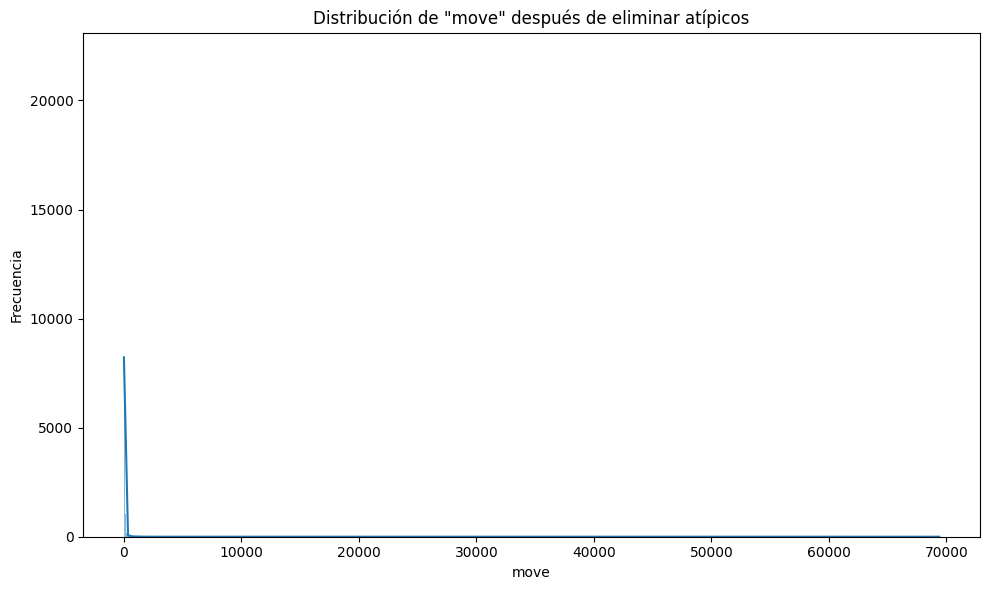

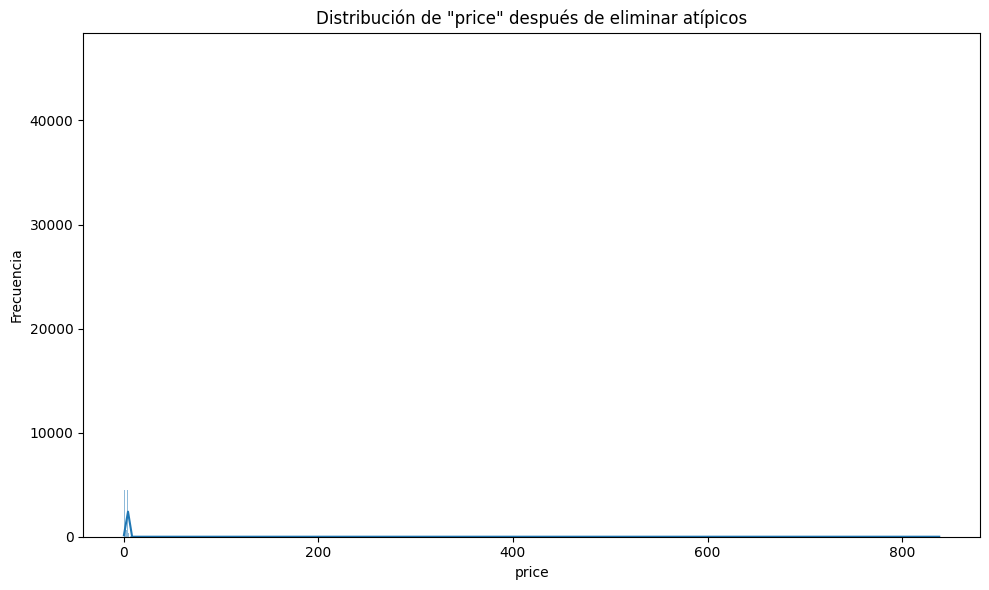

In [74]:
# --- Graficar la distribución de 'move' después de la limpieza ---
plt.figure(figsize=(10, 6))
sns.histplot(df_move_cleaned['move'], kde=True)
plt.title('Distribución de "move" después de eliminar atípicos')
plt.xlabel('move')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# --- Graficar la distribución de 'price' después de la limpieza ---
plt.figure(figsize=(10, 6))
sns.histplot(df_move_cleaned['price'], kde=True)
plt.title('Distribución de "price" después de eliminar atípicos')
plt.xlabel('price')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

El valor máximo actual de 'price' es: 838.16

Fila con el valor máximo de 'price':
         store         upc  week  move   price  qty sale  profit  ok  \
1250610     74  5400048040   322    43  838.16    1    B   99.94   1   

                price_hex        profit_hex  
1250610  408A3147AE147AE1  4058FC28F5C28F5C  

Forma del DataFrame después de eliminar el valor máximo de 'price': (1036034, 11)


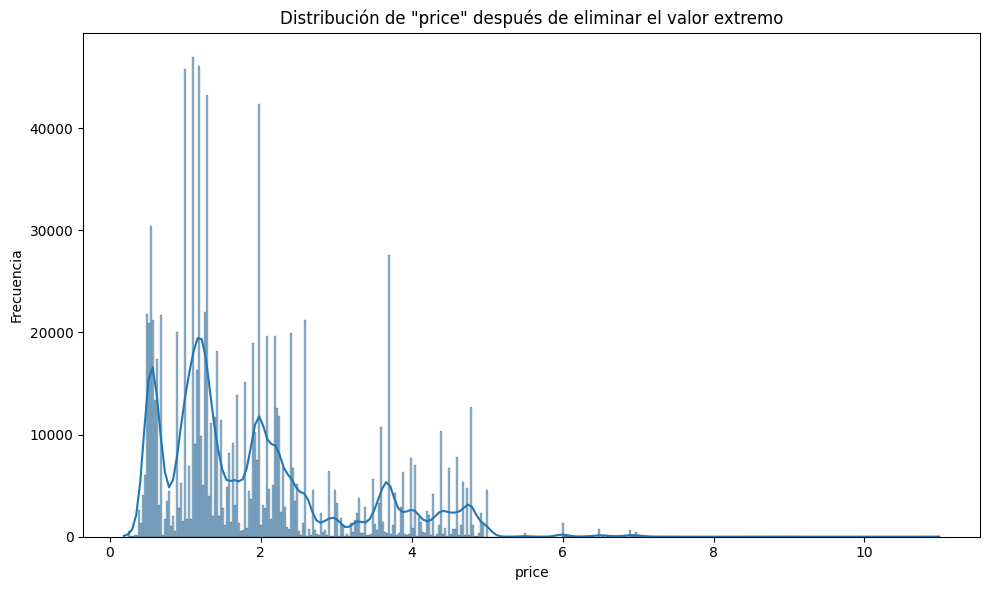

In [75]:
# --- Identificar el valor máximo de 'price' ---
max_price = df_move_cleaned['price'].max()
print(f"El valor máximo actual de 'price' es: {max_price}")

# --- Encontrar la fila donde 'price' tiene este valor máximo ---
fila_max_price = df_move_cleaned[df_move_cleaned['price'] == max_price]
print("\nFila con el valor máximo de 'price':")
print(fila_max_price)

# --- Eliminar la fila donde 'price' tiene este valor máximo ---
df_move_cleaned = df_move_cleaned[df_move_cleaned['price'] != max_price]

print(f"\nForma del DataFrame después de eliminar el valor máximo de 'price': {df_move_cleaned.shape}")

# --- Volver a graficar la distribución de 'price' después de eliminar el valor extremo ---
plt.figure(figsize=(10, 6))
sns.histplot(df_move_cleaned['price'], kde=True)
plt.title('Distribución de "price" después de eliminar el valor extremo')
plt.xlabel('price')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

El valor máximo actual de 'move' es: 69394

Fila con el valor máximo de 'move':
         store         upc  week   move  price  qty sale  profit  ok  \
1006135    111  5400041500   326  69394   0.25    1    B  -44.04   1   

                price_hex        profit_hex  
1006135  3FD0000000000000  C046051EB851EB85  

Forma del DataFrame después de eliminar el valor máximo de 'move': (1036033, 11)


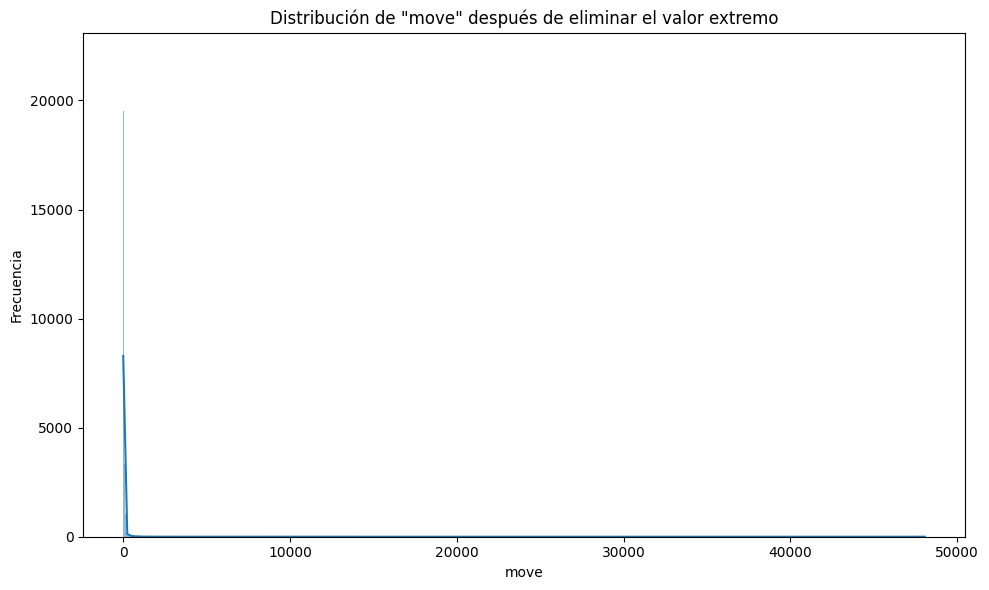

In [76]:
# --- Identificar el valor máximo de 'move' ---
max_move = df_move_cleaned['move'].max()
print(f"El valor máximo actual de 'move' es: {max_move}")

# --- Encontrar la fila donde 'move' tiene este valor máximo ---
fila_max_move = df_move_cleaned[df_move_cleaned['move'] == max_move]
print("\nFila con el valor máximo de 'move':")
print(fila_max_move)

# --- Eliminar la fila donde 'move' tiene este valor máximo ---
df_move_cleaned = df_move_cleaned[df_move_cleaned['move'] != max_move]

print(f"\nForma del DataFrame después de eliminar el valor máximo de 'move': {df_move_cleaned.shape}")

# --- Volver a graficar la distribución de 'move' después de eliminar el valor extremo ---
plt.figure(figsize=(10, 6))
sns.histplot(df_move_cleaned['move'], kde=True)
plt.title('Distribución de "move" después de eliminar el valor extremo')
plt.xlabel('move')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

Forma del DataFrame después de eliminar outliers de 'move' (IQR): (959855, 11)


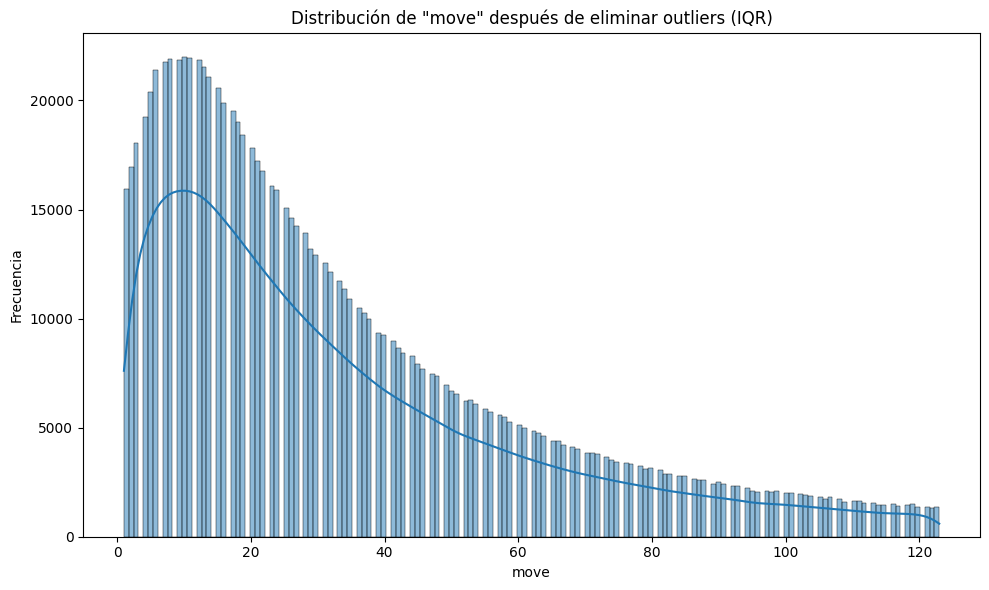

In [77]:
# --- Calcular el primer cuartil (Q1) y el tercer cuartil (Q3) de 'move' ---
Q1_move = df_move_cleaned['move'].quantile(0.25)
Q3_move = df_move_cleaned['move'].quantile(0.75)

# --- Calcular el IQR ---
IQR_move = Q3_move - Q1_move

# --- Definir los límites para identificar outliers ---
lower_bound_move = Q1_move - 1.5 * IQR_move
upper_bound_move = Q3_move + 1.5 * IQR_move

# --- Filtrar el DataFrame para mantener solo los valores dentro de los límites ---
df_move_cleaned = df_move_cleaned[(df_move_cleaned['move'] >= lower_bound_move) & (df_move_cleaned['move'] <= upper_bound_move)]

print(f"Forma del DataFrame después de eliminar outliers de 'move' (IQR): {df_move_cleaned.shape}")

# --- Volver a graficar la distribución de 'move' después de la eliminación de outliers ---
plt.figure(figsize=(10, 6))
sns.histplot(df_move_cleaned['move'], kde=True)
plt.title('Distribución de "move" después de eliminar outliers (IQR)')
plt.xlabel('move')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

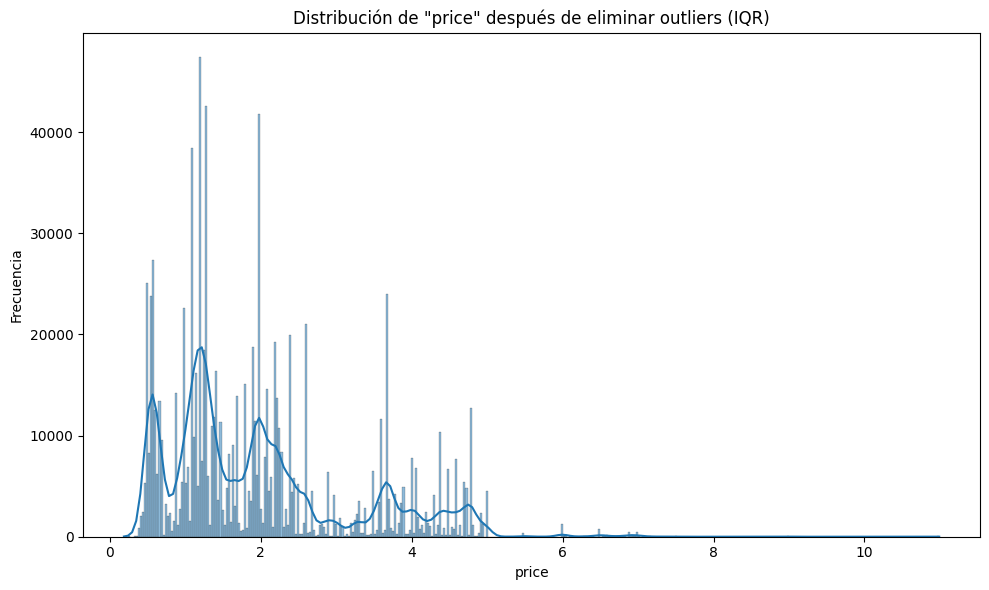

In [78]:
plt.figure(figsize=(10, 6))
sns.histplot(df_move_cleaned['price'], kde=True)
plt.title('Distribución de "price" después de eliminar outliers (IQR)')
plt.xlabel('price')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

#### **Análisis de Frecuencia para variables categóricas**

In [81]:
# --- Análisis de frecuencia de la variable 'sale' ---
print("\nAnálisis de frecuencia de la variable 'sale':")
print(df_move_cleaned['sale'].value_counts(dropna=False, normalize=True).round(4)*100)
print("\nNúmero de valores únicos en 'sale':", df_move_cleaned['sale'].nunique())

# --- Análisis de frecuencia de la variable 'upc' (mostrar las N categorías más frecuentes) ---
n_top_upcs = 20  # Puedes ajustar este número
print(f"\nAnálisis de frecuencia de las {n_top_upcs} 'upc' más frecuentes:")
print(df_move_cleaned['upc'].value_counts(normalize=True).head(n_top_upcs) * 100)
print("\nNúmero de valores únicos en 'upc':", df_move_cleaned['upc'].nunique())

print("\nNúmero de valores únicos en 'week':", df_move_cleaned['week'].nunique())


Análisis de frecuencia de la variable 'sale':
sale
NaN    82.61
B      14.12
S       3.24
C       0.02
G       0.00
Name: proportion, dtype: float64

Número de valores únicos en 'sale': 4

Análisis de frecuencia de las 20 'upc' más frecuentes:
upc
4200012100    3.212569
3040000048    2.858036
5400044700    2.798235
3700060311    2.788025
4200014800    2.745206
4200013700    2.672904
4200013100    2.636127
3700060511    2.598830
5400070000    2.548510
3700060571    2.460684
5400046530    2.375880
4200013000    2.341187
3828111217    2.296805
3828111129    2.228566
5400048800    2.208146
7331013205    2.188976
5400046520    2.120112
5400049400    2.076043
5400046510    2.056248
5400049410    2.026244
Name: proportion, dtype: float64

Número de valores únicos en 'upc': 124

Número de valores únicos en 'week': 384


#### **Análisis de correlación entre las variables numéricas**

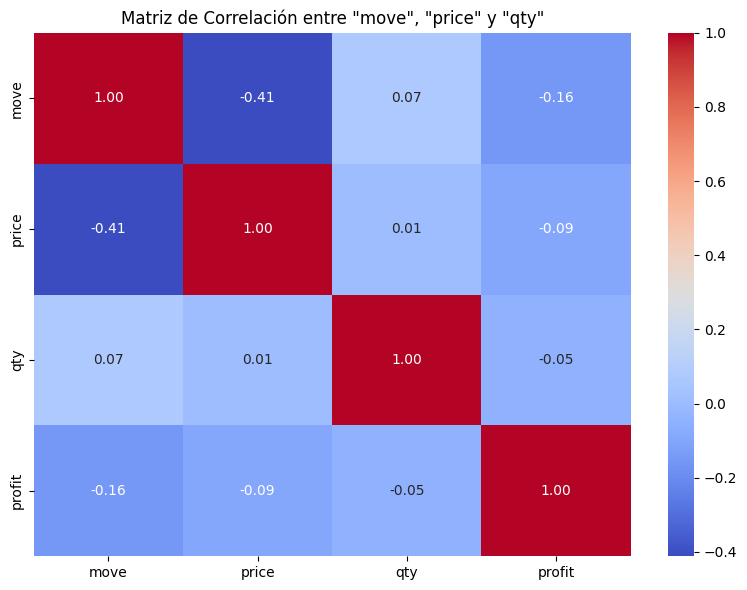

In [82]:
# --- Calcular la matriz de correlación ---
correlation_matrix = df_move_cleaned[['move', 'price', 'qty', 'profit']].corr(method='pearson')

# --- Crear la matriz de calor ---
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre "move", "price" y "qty"')
plt.tight_layout()
plt.show()

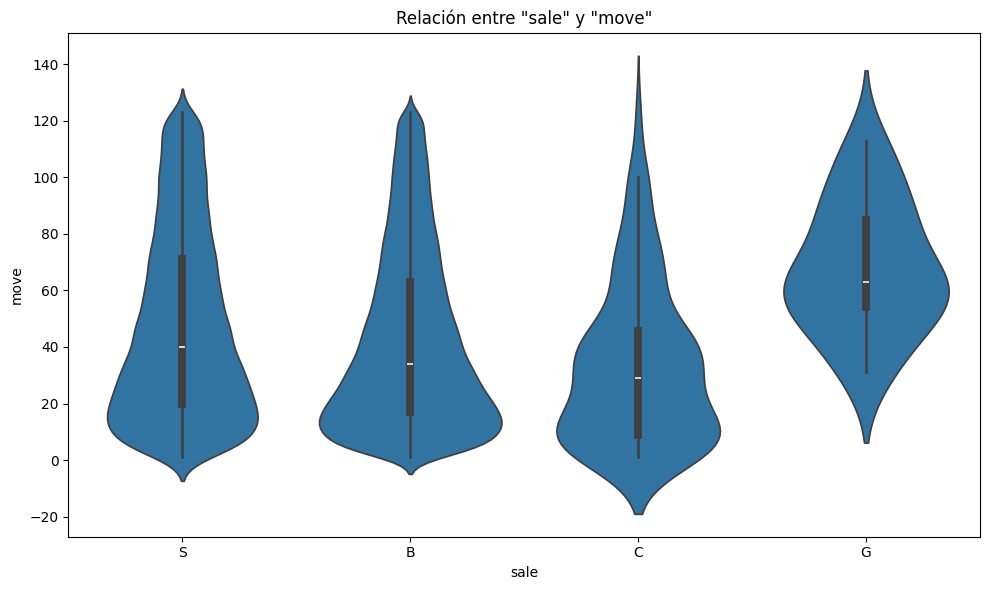

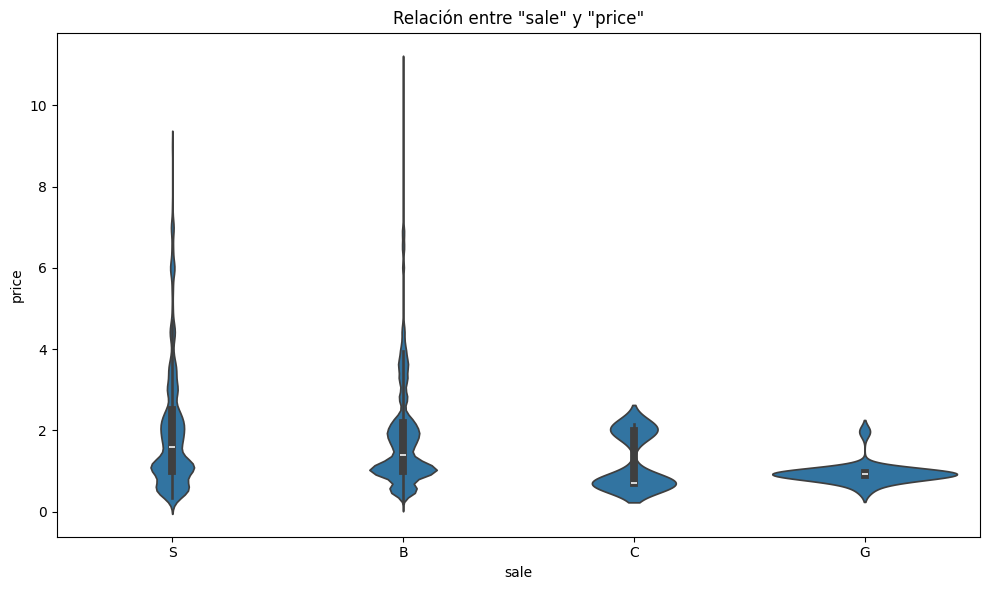

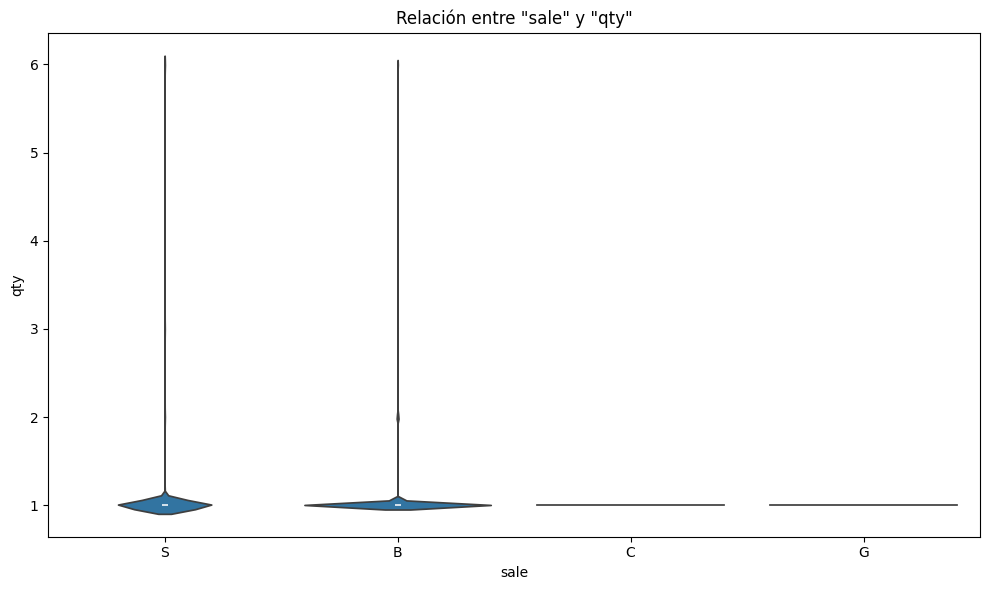

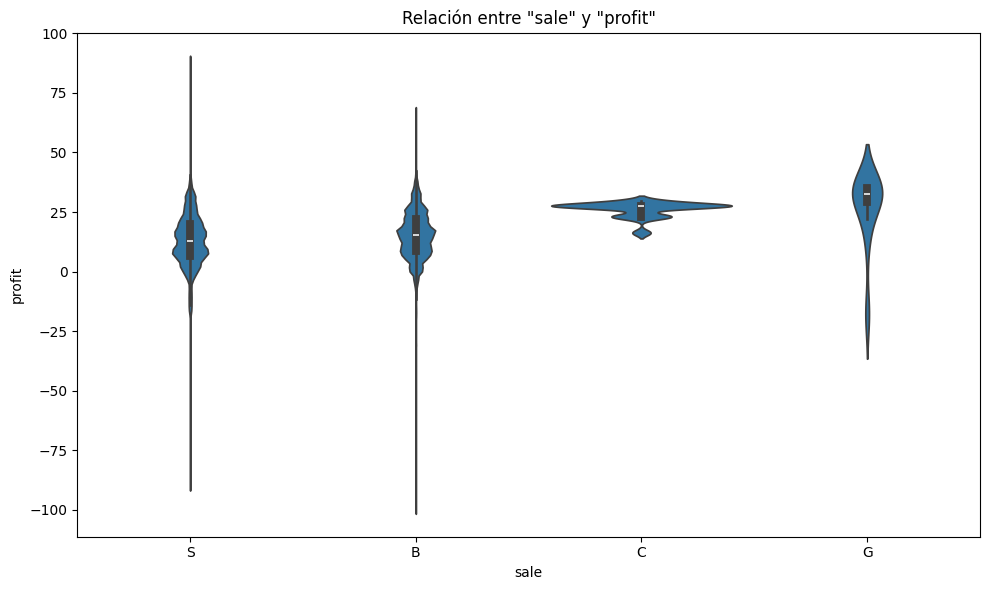

In [83]:
numerical_vars = ['move', 'price', 'qty', 'profit']
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='sale', y=var, data=df_move_cleaned)
    plt.title(f'Relación entre "sale" y "{var}"')
    plt.xlabel('sale')
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()

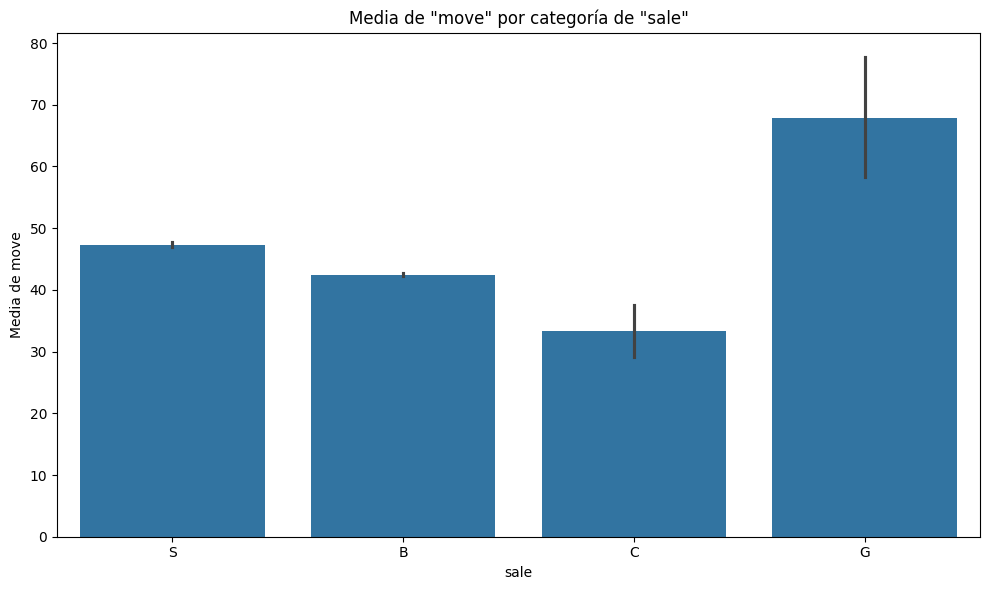

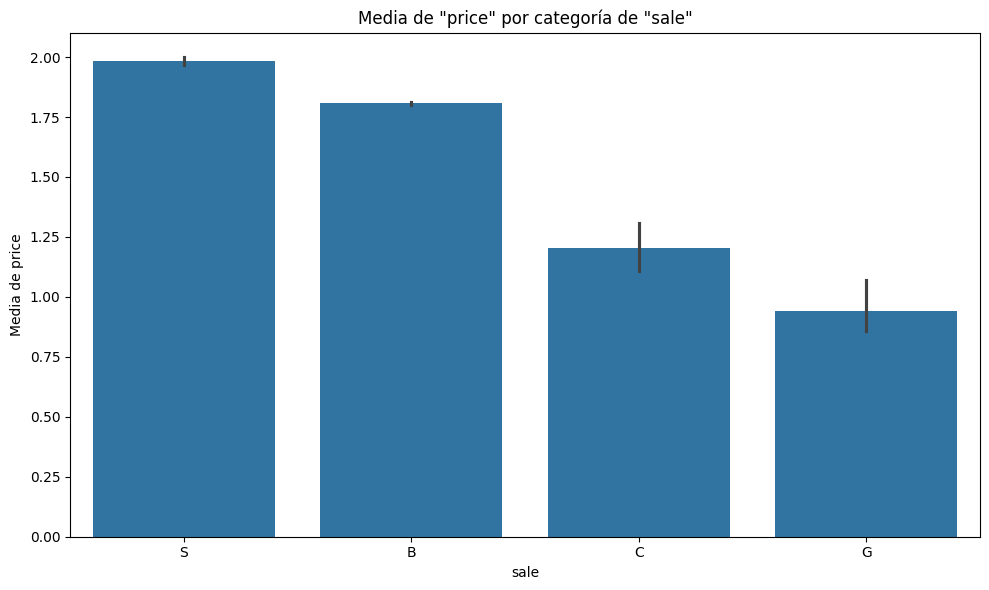

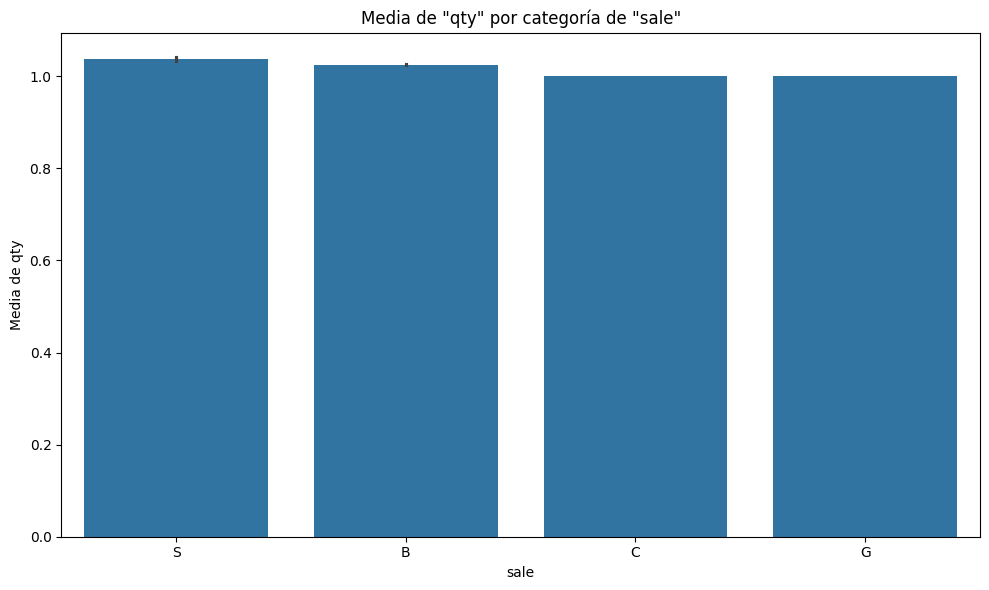

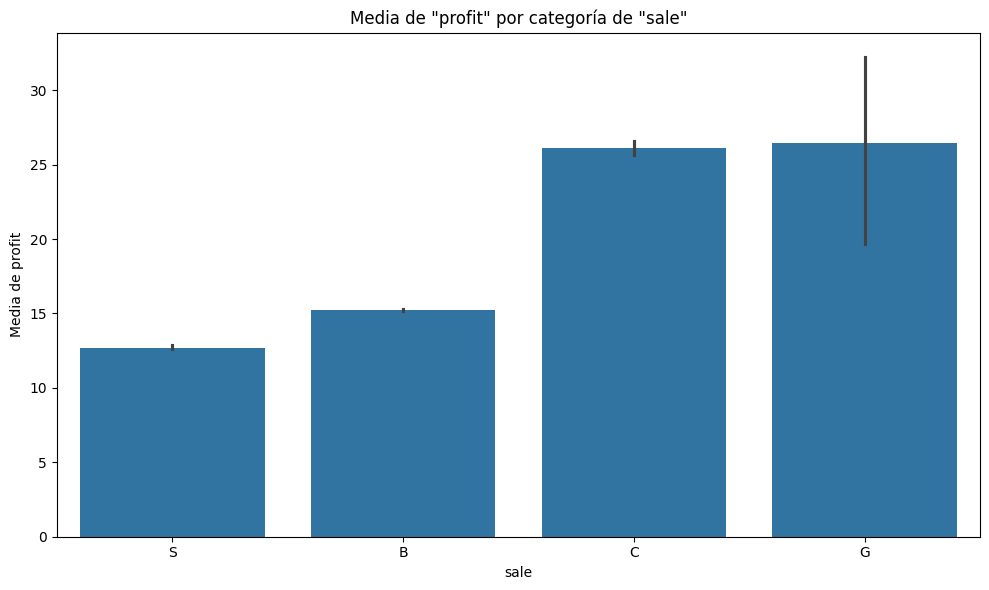

In [84]:
numerical_vars = ['move', 'price', 'qty', 'profit']
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='sale', y=var, data=df_move_cleaned, errorbar='ci') # errorbar='ci' muestra intervalos de confianza
    plt.title(f'Media de "{var}" por categoría de "sale"')
    plt.xlabel('sale')
    plt.ylabel(f'Media de {var}')
    plt.tight_layout()
    plt.show()

#### **Análisis de tendencia y estacionalidad**


Primeras filas de la serie de tiempo agregada por semana:
           move     price       qty     profit
week                                          
1     50.388295  1.686318  1.000000  14.901303
2     51.263522  1.724805  1.023899  15.148805
3     54.175399  1.629556  1.000000  16.317779
4     52.404040  1.662008  1.041592  16.005716
5     51.908973  1.654792  1.038362  15.463739


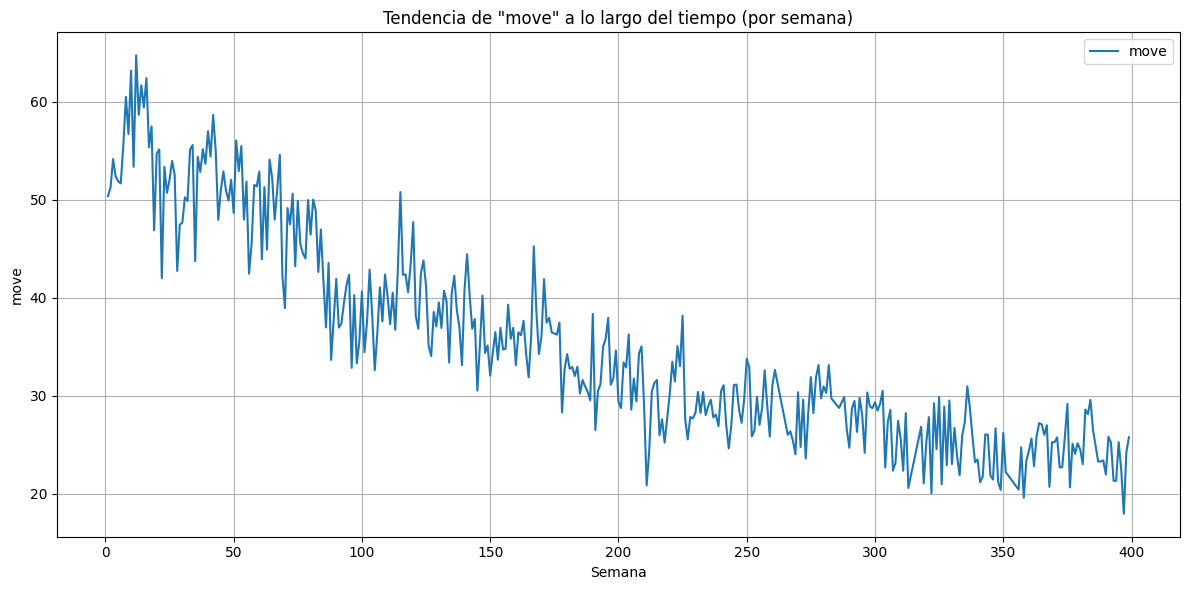

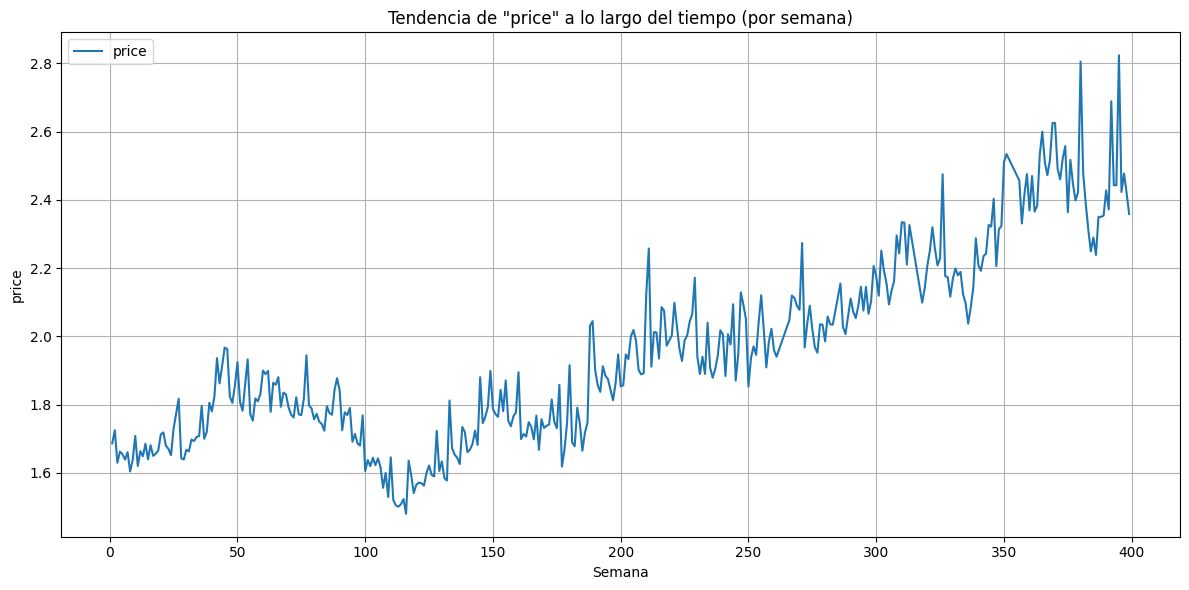

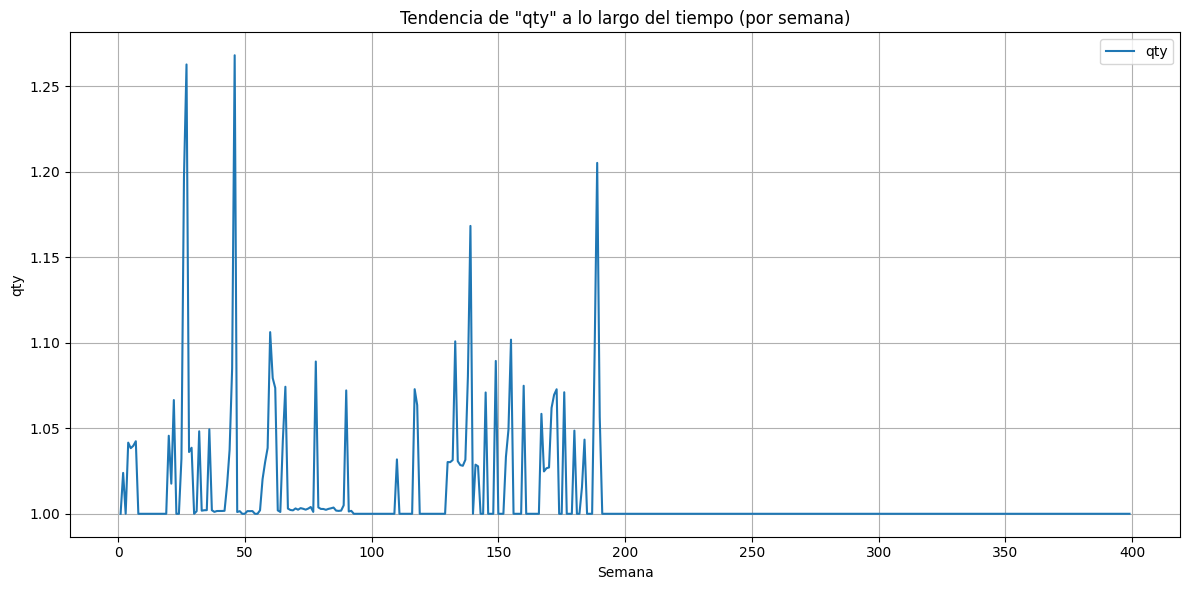

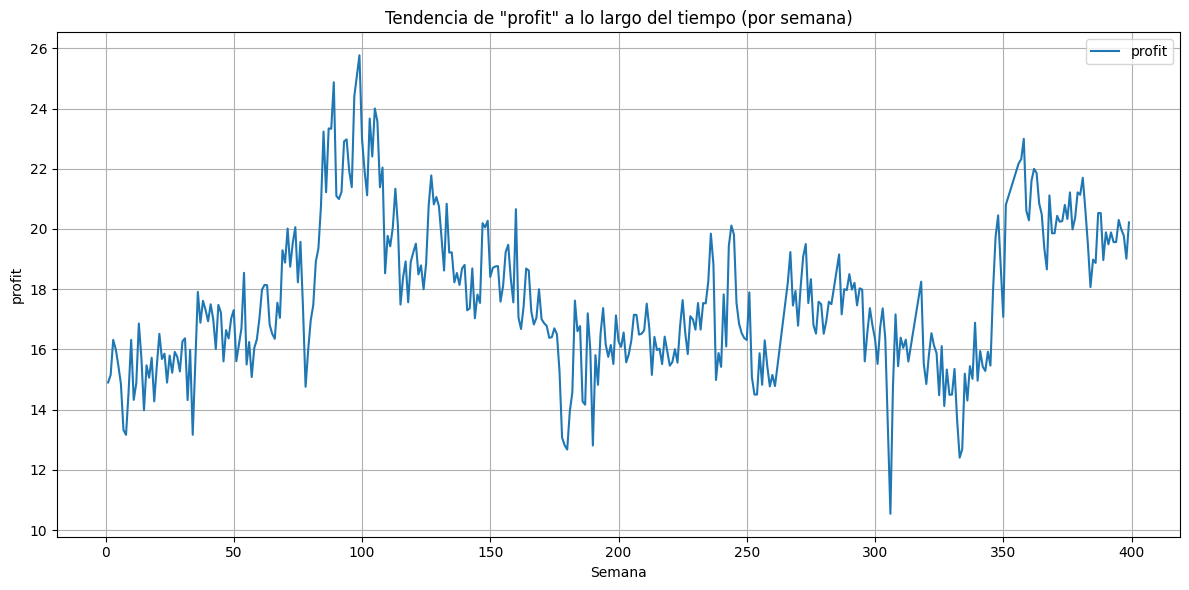

In [85]:
# --- Agrupar por 'week' y calcular la media de las variables numéricas ---
time_series_data = df_move_cleaned.groupby('week')[['move', 'price', 'qty', 'profit']].mean()

# --- Mostrar las primeras filas de la serie de tiempo ---
print("\nPrimeras filas de la serie de tiempo agregada por semana:")
print(time_series_data.head())

# --- Graficar las series de tiempo ---
numerical_vars = ['move', 'price', 'qty', 'profit']
for var in numerical_vars:
    plt.figure(figsize=(12, 6))
    plt.plot(time_series_data.index, time_series_data[var], label=var)
    plt.title(f'Tendencia de "{var}" a lo largo del tiempo (por semana)')
    plt.xlabel('Semana')
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### **Creación de datos sintéticos**

In [ ]:
#Generamos week
num_synthetic_samples = 1000000

# ultima semana de los datos reales
last_real_week = df_move_cleaned['week'].max()
print(f"La última semana en los datos reales es: {last_real_week}")
start_synthetic_week = last_real_week + 1
end_synthetic_week = start_synthetic_week + num_synthetic_samples // (df_move_cleaned.shape[0] // df_move_cleaned['week'].nunique()) + 1 
synthetic_week = np.random.randint(start_synthetic_week, end_synthetic_week, num_synthetic_samples)
synthetic_data = pd.DataFrame({'week': synthetic_week})

La última semana en los datos reales es: 399


In [89]:
#Generamos UPC 
upc_probabilities = df_move_cleaned['upc'].value_counts(normalize=True).to_dict()
synthetic_upc = np.random.choice(list(upc_probabilities.keys()), num_synthetic_samples, p=list(upc_probabilities.values()))
synthetic_data['upc'] = synthetic_upc

In [90]:
#Generamos Sale
sale_probabilities = df_move_cleaned['sale'].value_counts(dropna=False, normalize=True).to_dict()
synthetic_sale = np.random.choice(list(sale_probabilities.keys()), num_synthetic_samples, p=list(sale_probabilities.values()))
synthetic_data['sale'] = synthetic_sale

In [96]:
# Generamos move
def generate_move_extended(row):
    sale = row['sale']
    week = row['week']
    
    week_offset = week - last_real_week
    if sale == 'G':
        return np.random.gamma(shape=5, scale=15)
    elif sale == 'S':
        return np.random.gamma(shape=3, scale=10 - (week_offset / 50))
    elif sale == 'B':
        return np.random.gamma(shape=4, scale=9 - (week_offset / 60))
    elif pd.isna(sale): 
        return np.random.gamma(shape=2, scale=7 - (week_offset / 70)) 
    else: 
        return np.random.gamma(shape=2, scale=7 - (week_offset / 70))

synthetic_data['move'] = synthetic_data.apply(generate_move_extended, axis=1).round().astype(int)
synthetic_data['move'] = np.clip(synthetic_data['move'], 0, None)


In [93]:
# Genermos price
def generate_price_extended(row):
    sale = row['sale']
    week = row['week']
    
    week_offset = week - last_real_week
    if sale == 'G':
        return np.random.lognormal(mean=np.log(0.5 + min(0.5, (week_offset / 500) * 0.2)), sigma=0.1)
    elif sale == 'S':
        return np.random.lognormal(mean=np.log(1.0 + min(0.7, (week_offset / 400) * 0.5)), sigma=0.2)
    elif sale == 'B':
        return np.random.lognormal(mean=np.log(1.0 + min(0.6, (week_offset / 450) * 0.4)), sigma=0.15)
    elif sale == 'C':
        return np.random.lognormal(mean=np.log(0.8 + min(0.4, (week_offset / 600) * 0.3)), sigma=0.08)
    else: # sale is NaN
        return np.random.lognormal(mean=np.log(1.2 + min(0.8, (week_offset / 350) * 0.6)), sigma=0.25)

synthetic_data['price'] = synthetic_data.apply(generate_price_extended, axis=1)
synthetic_data['price'] = np.clip(synthetic_data['price'], 0.1, None)

In [94]:
# Generamos profit
def generate_profit_extended(row):
    sale = row['sale']
    if sale == 'G':
        return np.random.normal(loc=26.5, scale=10)
    elif sale == 'C':
        return np.random.normal(loc=26, scale=5)
    elif sale == 'B':
        return np.random.normal(loc=15, scale=8)
    elif sale == 'S':
        return np.random.normal(loc=12.5, scale=9)
    else: # sale is NaN
        return np.random.normal(loc=10, scale=12)

synthetic_data['profit'] = synthetic_data.apply(generate_profit_extended, axis=1)


In [95]:
#Generamos qty
def generate_qty_extended(row):
    if pd.isna(row['sale']):
        return 1
    else:
        return 1

synthetic_data['qty'] = synthetic_data.apply(generate_qty_extended, axis=1).astype(int)
synthetic_data['qty'] = np.clip(synthetic_data['qty'], 1, None)

In [91]:
#Generamos store
store_probabilities = df_move_cleaned['store'].value_counts(normalize=True).to_dict()
synthetic_store = np.random.choice(list(store_probabilities.keys()), num_synthetic_samples, p=list(store_probabilities.values()))
synthetic_data['store'] = synthetic_store

In [97]:
#Concateno el dataset sintético con el real
combined_data = pd.concat([df_move_cleaned, synthetic_data], ignore_index=True)

# --- Mostrar la forma del DataFrame combinado ---
print("Forma del DataFrame de datos reales:", df_move_cleaned.shape)
print("Forma del DataFrame de datos sintéticos:", synthetic_data.shape)
print("Forma del DataFrame combinado:", combined_data.shape)

# --- Mostrar las primeras filas del DataFrame combinado ---
print("\nPrimeras filas del DataFrame combinado:")
print(combined_data.head())

# --- Mostrar las últimas filas del DataFrame combinado (que deberían ser los datos sintéticos) ---
print("\nÚltimas filas del DataFrame combinado:")
print(combined_data.tail())

Forma del DataFrame de datos reales: (959855, 11)
Forma del DataFrame de datos sintéticos: (1000000, 8)
Forma del DataFrame combinado: (1959855, 11)

Primeras filas del DataFrame combinado:
   store         upc  week  move  price  qty sale  profit   ok  \
0      2  1122542346   338     1   2.09    1  NaN    13.3  1.0   
1      2  1122542346   339     4   2.09    1  NaN    13.3  1.0   
2      2  1122542346   340     7   2.09    1  NaN    13.3  1.0   
3      2  1122542346   341     9   2.09    1  NaN    13.3  1.0   
4      2  1122542346   342     3   2.09    1  NaN    13.3  1.0   

          price_hex        profit_hex  
0  4000B851EB851EB8  402A99999999999A  
1  4000B851EB851EB8  402A99999999999A  
2  4000B851EB851EB8  402A99999999999A  
3  4000B851EB851EB8  402A99999999999A  
4  4000B851EB851EB8  402A99999999999A  

Últimas filas del DataFrame combinado:
         store         upc  week  move     price  qty sale     profit  ok  \
1959850     98  4200010500   598    40  0.990427    1   

# **Análisis descriptivo de los datos y preparación del dataset final**

1. Se realizan gráficos descriptivos
2. Tratamiento de Nan y nulos
3. Revisión de atípicos (Se define no eliminarlos)
4. Se crea una variabl Value que corresponde al valor ganado (Precio*cantidad vendida*ganancia)
5. Se estandarizan las variables numéricas

In [99]:
print("\nEstadísticas Descriptivas de Variables Numéricas en el DataFrame Combinado:")
print(combined_data[['move', 'price', 'qty', 'profit']].describe().round(2))


Estadísticas Descriptivas de Variables Numéricas en el DataFrame Combinado:
             move       price         qty      profit
count  1959855.00  1959855.00  1959855.00  1959855.00
mean        22.02        1.74        1.00       14.15
std         24.02        0.95        0.11       11.57
min          0.00        0.19        1.00      -99.79
25%          6.00        1.16        1.00        7.04
50%         13.00        1.48        1.00       14.57
75%         29.00        2.02        1.00       21.01
max        167.00       10.99        7.00       90.54


In [ ]:
#Eliminamos filas donde move es 0
combined_data_cleaned = combined_data[combined_data['move'] > 0].copy()

# DataFrame antes y después de la eliminación
print("Forma del DataFrame combinado antes de eliminar valores 0 en 'move':", combined_data.shape)
print("Forma del DataFrame combinado después de eliminar valores 0 en 'move':", combined_data_cleaned.shape)
print("\nEstadísticas Descriptivas de Variables Numéricas en el DataFrame Combinado:")
print(combined_data_cleaned[['move', 'price', 'qty', 'profit']].describe().round(2))


Forma del DataFrame combinado antes de eliminar valores 0 en 'move': (1959855, 11)
Forma del DataFrame combinado después de eliminar valores 0 en 'move': (1949680, 11)

Estadísticas Descriptivas de Variables Numéricas en el DataFrame Combinado:
             move       price         qty      profit
count  1949680.00  1949680.00  1949680.00  1949680.00
mean        22.13        1.74        1.00       14.17
std         24.03        0.95        0.11       11.57
min          1.00        0.19        1.00      -99.79
25%          6.00        1.16        1.00        7.06
50%         13.00        1.48        1.00       14.59
75%         29.00        2.02        1.00       21.02
max        167.00       10.99        7.00       90.54


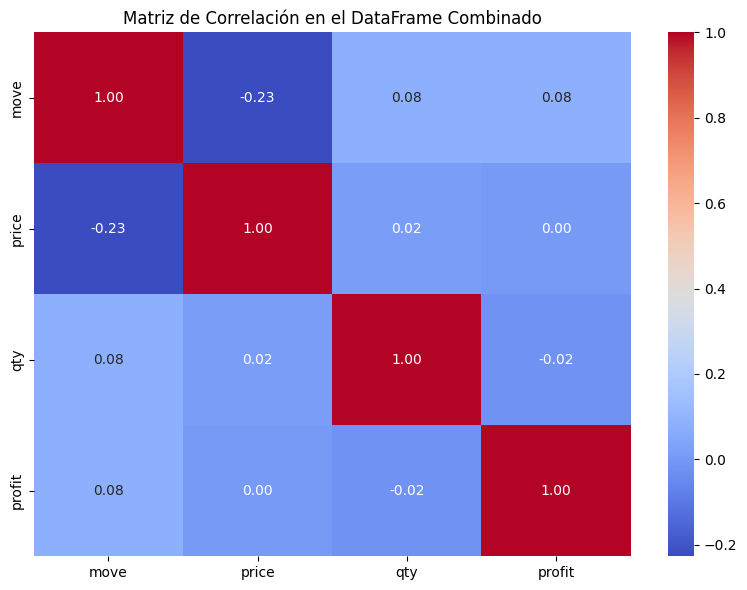

In [ ]:
#Matriza de correlación
correlation_matrix_combined = combined_data[['move', 'price', 'qty', 'profit']].corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_combined, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación en el DataFrame Combinado')
plt.tight_layout()
plt.show()

In [ ]:
#Análisis de frecuencias de las variables categóricas
print("\nFrecuencia de la Variable 'sale' en el DataFrame Combinado:")
print(combined_data['sale'].value_counts(dropna=False, normalize=True) * 100)
print("\nNúmero de valores únicos en 'sale':", combined_data['sale'].nunique())

print("\nFrecuencia de las 20 'upc' más frecuentes en el DataFrame Combinado:")
print(combined_data['upc'].value_counts(normalize=True).head(20) * 100)
print("\nNúmero de valores únicos en 'upc':", combined_data['upc'].nunique())

print("\nFrecuencia de las 20 'store' más frecuentes en el DataFrame Combinado:")
print(combined_data['store'].value_counts(normalize=True).head(20) * 100)
print("\nNúmero de valores únicos en 'store':", combined_data['store'].nunique())

print("\nFrecuencia de la Variable 'week' en el DataFrame Combinado:")
print(combined_data['week'].value_counts(normalize=True).head(10) * 100) # Mostrar las 10 más frecuentes
print("\nNúmero de valores únicos en 'week':", combined_data['week'].nunique())


Frecuencia de la Variable 'sale' en el DataFrame Combinado:
sale
nan    42.156231
NaN    40.460085
B      14.109666
S       3.254680
C       0.017195
G       0.002143
Name: proportion, dtype: float64

Número de valores únicos en 'sale': 5

Frecuencia de las 20 'upc' más frecuentes en el DataFrame Combinado:
upc
4200012100    3.205594
3040000048    2.850925
5400044700    2.790615
3700060311    2.776532
4200014800    2.731529
4200013700    2.664228
4200013100    2.640042
3700060511    2.602744
5400070000    2.560547
3700060571    2.465846
5400046530    2.375380
4200013000    2.342367
3828111217    2.301038
3828111129    2.242309
5400048800    2.207204
7331013205    2.181692
5400046520    2.113626
5400049400    2.076735
5400046510    2.045611
5400049410    2.025048
Name: proportion, dtype: float64

Número de valores únicos en 'upc': 124

Frecuencia de las 20 'store' más frecuentes en el DataFrame Combinado:
store
54     1.314587
106    1.297851
56     1.295963
115    1.291371
59     1.28

In [ ]:
# Tratamiento de datos Nan en la variable sale
combined_data_cleaned['sale'] = combined_data_cleaned['sale'].replace(['nan', 'NaN', np.nan], 'no_aplica')

# Calculamos nuevamente las frecuencias
print("\nFrecuencia de la Variable 'sale' después de la unificación (corrección):")
print(combined_data_cleaned['sale'].value_counts(dropna=False, normalize=True).round(4) * 100)
print("\nNúmero de valores únicos en 'sale':", combined_data_cleaned['sale'].nunique())


Frecuencia de la Variable 'sale' después de la unificación (corrección):
sale
no_aplica    82.53
B            14.18
S             3.27
C             0.02
G             0.00
Name: proportion, dtype: float64

Número de valores únicos en 'sale': 5



--- Estadísticas Descriptivas de Variables Numéricas en el DataFrame Limpio Combinado ---
             move       price         qty      profit
count  1949680.00  1949680.00  1949680.00  1949680.00
mean        22.13        1.74        1.00       14.17
std         24.03        0.95        0.11       11.57
min          1.00        0.19        1.00      -99.79
25%          6.00        1.16        1.00        7.06
50%         13.00        1.48        1.00       14.59
75%         29.00        2.02        1.00       21.02
max        167.00       10.99        7.00       90.54

--- Matriz de Correlación entre Variables Numéricas en el DataFrame Limpio Combinado ---
            move     price       qty    profit
move    1.000000 -0.227518  0.079926  0.078249
price  -0.227518  1.000000  0.015975  0.003360
qty     0.079926  0.015975  1.000000 -0.016369
profit  0.078249  0.003360 -0.016369  1.000000


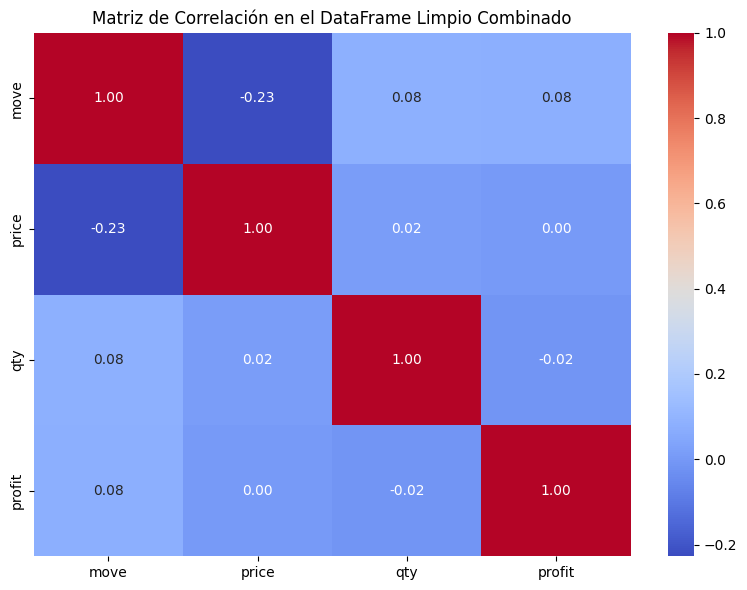


--- Frecuencia de la Variable 'sale' en el DataFrame Limpio Combinado ---
sale
no_aplica    82.525902
B            14.183251
S             3.271460
C             0.017234
G             0.002154
Name: proportion, dtype: float64

Número de valores únicos en 'sale': 5

--- Frecuencia de las 20 'upc' más frecuentes en el DataFrame Limpio Combinado ---
upc
4200012100    3.205398
3040000048    2.849852
5400044700    2.790612
3700060311    2.776866
4200014800    2.731628
4200013700    2.663206
4200013100    2.640638
3700060511    2.601606
5400070000    2.560984
3700060571    2.466097
5400046530    2.376031
4200013000    2.342743
3828111217    2.302173
3828111129    2.243240
5400048800    2.207080
7331013205    2.181384
5400046520    2.113526
5400049400    2.076648
5400046510    2.046131
5400049410    2.025512
Name: proportion, dtype: float64

Número de valores únicos en 'upc': 124

--- Frecuencia de las 20 'store' más frecuentes en el DataFrame Limpio Combinado ---
store
54     1.315395
106 

In [117]:
 #1. Estadísticas Descriptivas de Variables Numéricas
print("\n--- Estadísticas Descriptivas de Variables Numéricas en el DataFrame Limpio Combinado ---")
print(combined_data_cleaned[['move', 'price', 'qty', 'profit']].describe().round(2))

# 2. Correlaciones entre Variables Numéricas
correlation_matrix_cleaned = combined_data_cleaned[['move', 'price', 'qty', 'profit']].corr(method='pearson')
print("\n--- Matriz de Correlación entre Variables Numéricas en el DataFrame Limpio Combinado ---")
print(correlation_matrix_cleaned)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación en el DataFrame Limpio Combinado')
plt.tight_layout()
plt.show()

# 3. Frecuencias de Variables Categóricas
print("\n--- Frecuencia de la Variable 'sale' en el DataFrame Limpio Combinado ---")
print(combined_data_cleaned['sale'].value_counts(dropna=False, normalize=True) * 100)
print("\nNúmero de valores únicos en 'sale':", combined_data_cleaned['sale'].nunique())

print("\n--- Frecuencia de las 20 'upc' más frecuentes en el DataFrame Limpio Combinado ---")
print(combined_data_cleaned['upc'].value_counts(normalize=True).head(20) * 100)
print("\nNúmero de valores únicos en 'upc':", combined_data_cleaned['upc'].nunique())

print("\n--- Frecuencia de las 20 'store' más frecuentes en el DataFrame Limpio Combinado ---")
print(combined_data_cleaned['store'].value_counts(normalize=True).head(20) * 100)
print("\nNúmero de valores únicos en 'store':", combined_data_cleaned['store'].nunique())

print("\n--- Frecuencia de las 10 'week' más frecuentes en el DataFrame Limpio Combinado ---")
print(combined_data_cleaned['week'].value_counts(normalize=True).head(10) * 100)
print("\nNúmero de valores únicos en 'week':", combined_data_cleaned['week'].nunique())

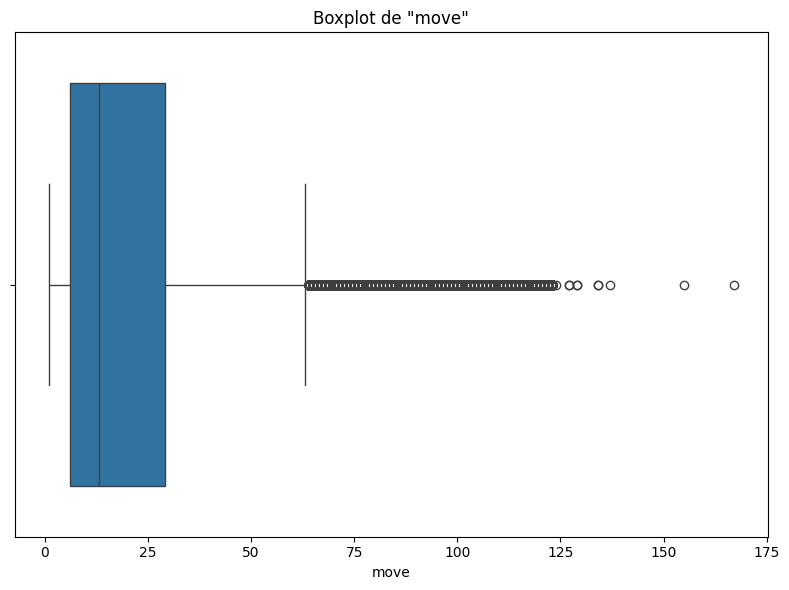

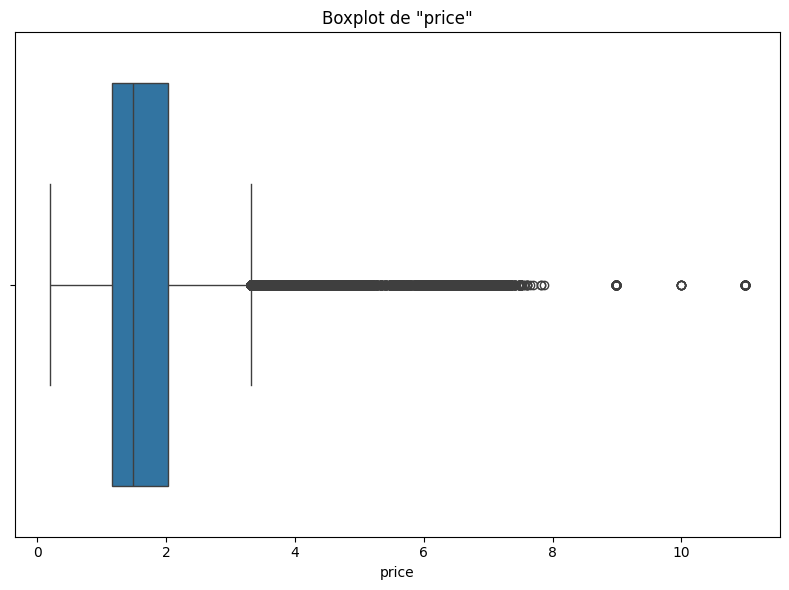

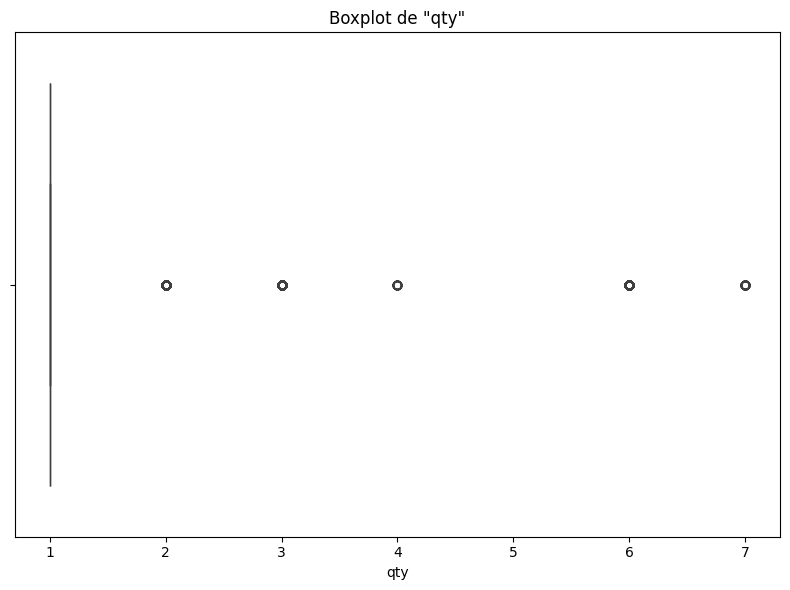

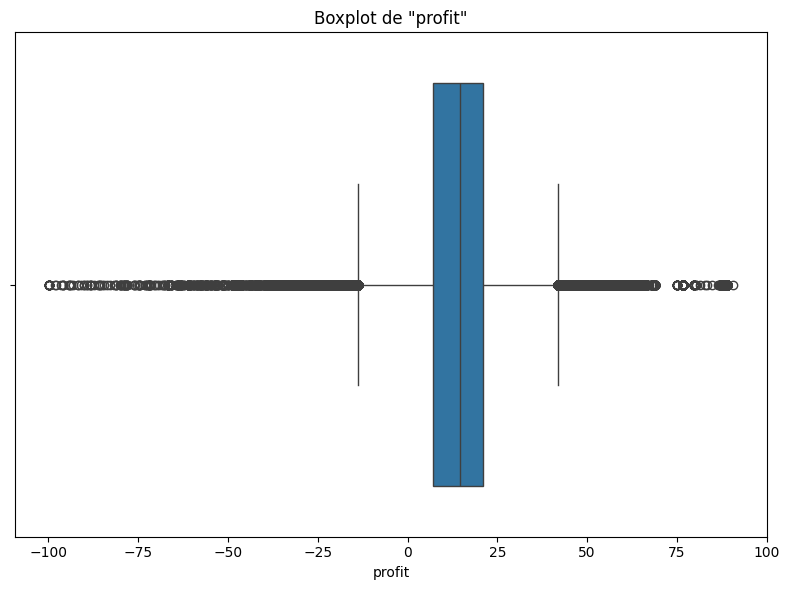

In [ ]:
#Analizamos los outliers
numerical_cols = ['move', 'price', 'qty', 'profit']

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=combined_data_cleaned[col])
    plt.title(f'Boxplot de "{col}"')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [129]:
# Creamos la nueva variable value
combined_data_cleaned['value'] = combined_data_cleaned['price'] * combined_data_cleaned['move'] * (combined_data_cleaned['profit']/100)

# Mostrar las primeras filas del DataFrame con la nueva columna
print("\nPrimeras filas del DataFrame con la nueva columna 'value':")
print(combined_data_cleaned.head())

# Estadisticas descriptivas con Value
print("\nEstadísticas Descriptivas de la nueva columna 'value':")
print(combined_data_cleaned['value'].describe().round(2))


Primeras filas del DataFrame con la nueva columna 'value':
   store         upc  week      move     price       qty       sale    profit  \
0      2  1122542346   338 -0.879338  0.365741 -0.040677  no_aplica -0.075593   
1      2  1122542346   339 -0.754512  0.365741 -0.040677  no_aplica -0.075593   
2      2  1122542346   340 -0.629687  0.365741 -0.040677  no_aplica -0.075593   
3      2  1122542346   341 -0.546470  0.365741 -0.040677  no_aplica -0.075593   
4      2  1122542346   342 -0.796121  0.365741 -0.040677  no_aplica -0.075593   

    ok         price_hex        profit_hex     value  
0  1.0  4000B851EB851EB8  402A99999999999A  0.000243  
1  1.0  4000B851EB851EB8  402A99999999999A  0.000209  
2  1.0  4000B851EB851EB8  402A99999999999A  0.000174  
3  1.0  4000B851EB851EB8  402A99999999999A  0.000151  
4  1.0  4000B851EB851EB8  402A99999999999A  0.000220  

Estadísticas Descriptivas de la nueva columna 'value':
count    1949680.00
mean          -0.00
std            0.01
min    

In [128]:
# Variables a estandarizar
numerical_cols_to_standardize = ['move', 'price', 'qty', 'profit', 'value']

scaler = StandardScaler()

#Ajustar el scaler a los datos y transformar las columnas 
combined_data_cleaned[numerical_cols_to_standardize] = scaler.fit_transform(combined_data_cleaned[numerical_cols_to_standardize])

print("\nPrimeras filas del DataFrame con las variables numéricas estandarizadas:")
print(combined_data_cleaned.head())

# Estadísticas descriptivas de las variables estandarizadas
print("\nEstadísticas Descriptivas de las variables numéricas estandarizadas:")
print(combined_data_cleaned[numerical_cols_to_standardize].describe())


Primeras filas del DataFrame con las variables numéricas estandarizadas:
   store         upc  week      move     price       qty       sale    profit  \
0      2  1122542346   338 -0.879338  0.365741 -0.040677  no_aplica -0.075593   
1      2  1122542346   339 -0.754512  0.365741 -0.040677  no_aplica -0.075593   
2      2  1122542346   340 -0.629687  0.365741 -0.040677  no_aplica -0.075593   
3      2  1122542346   341 -0.546470  0.365741 -0.040677  no_aplica -0.075593   
4      2  1122542346   342 -0.796121  0.365741 -0.040677  no_aplica -0.075593   

    ok         price_hex        profit_hex     value  
0  1.0  4000B851EB851EB8  402A99999999999A  0.099184  
1  1.0  4000B851EB851EB8  402A99999999999A  0.095494  
2  1.0  4000B851EB851EB8  402A99999999999A  0.091803  
3  1.0  4000B851EB851EB8  402A99999999999A  0.089342  
4  1.0  4000B851EB851EB8  402A99999999999A  0.096724  

Estadísticas Descriptivas de las variables numéricas estandarizadas:
               move         price      

### Limitaciones del dataset

1. Segun la documentación del dataset, es posible que haya algunos días donde no se haya marcado con S(reducción de precio) y tuviera reducción de precio, entonces puede ser posible que no se capture todos los efectos promocionales.
2. Debido a la antiguedad del dataset se realizó la creación de datos sintéticos a partir de los datos reales, conociendo su comportamiento, tendencias, estacionalidad, relaciones entre variables. 
3. El dataset contaba con datos atípicos que podrían haber correspondido a promociones, pero que era muy dificil de identificar.